# Recomendador de inversiones inmoviliarias

## Datos origen:

- [Precio_medio_EUR_m2_alquiler](datasets/Precio_medio_EUR_m2_alquiler.csv)
- [Precio_medio_EUR_m2_compraventa](datasets/Precio_medio_EUR_m2_compraventa.csv)
- [BarcelonaCiutat_SeccionsCensals](datasets/BarcelonaCiutat_SeccionsCensals.csv)
- [idealista_datafile](datasets/idealista_datafile.csv)


## Tareas:

1. Dentificar toda la jerarquia de distritos y barrios
1. Modelo de ML para extrapolar precios estadístico de alquiler y compraventa a fecha de hoy
1. Asignar precio estadístico de alquiler y compraventa a cada inmueble basado en su barrio o distrito
1. Crear una puntuación para cada barrio o distrito de 0 a 1
1. Crear una puntuación para el precio de compra para cada inmueble de 0 a 1 en función del precio estadístico de compra de cada barrio o distrito
1. Crear una puntuación para el precio de alquiler para cada inmueble de 0 a 1 en función del precio estadístico de alquiler de cada barrio o distrito
1. Calcular la tasa de retorno de cada inmueble en función del precio de compra y el precio de alquiler
1. Crear una puntuación final para cada inmueble de 0 a 1 en función de las puntuaciones anteriores


In [1]:
!pip install openpyxl scikit-learn

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


## Carga de datos de Barcelona Datos con el Precio medio por superficie (€/m²) del alquiler de viviendas por distrito

Renta media mensual por superficie (€/m²) de alquiler de viviendas procedente de la estadística de fianzas del INCASOL. Se puede considerar que esta estadística tiene un carácter censal ya que se basa en el recuento de todos los contratos de alquiler que han depositado la fianza en el Incasòl en el período considerado.

La información de distritos y barrios está elaborada a partir de aquéllos viviendas que se han podido geolocalizar. El total de Barcelona puede no coincidir con la suma de compraventas de los distritos o de los barrios.No se publica la información de los ámbitos de menos de seis contratos registrados.

In [3]:
# Carga de datos de Barcelona Datos con el Precio medio por superficie (€/m²) del alquiler de viviendas por distrito

# Cargar estructura de jerarquica de municipio - distrito - barrio
# SeccionsCensals = pd.read_csv('datasets/BarcelonaCiutat_SeccionsCensals.csv')
# barrios = SeccionsCensals.groupby('nom_barri').min().drop(['codi_seccio_censal','geometria_etrs89','geometria_wgs84','codi_aeb'], axis=1).sort_values(by='codi_barri').reset_index().copy()

bcn_precios_int = pd.read_csv('datasets/gen_bcn_precios_int.csv')
bcn_precios = pd.read_csv('datasets/gen_bcn_precios.csv')
gen_bcn_estats = pd.read_csv("datasets/gen_bcn_estats.csv")

# Conversión de mes a periodo
bcn_precios['mes'] = pd.to_datetime(bcn_precios['mes'])#.dt.to_period('M')
bcn_precios_int['mes'] = pd.to_datetime(bcn_precios_int['mes'])#.dt.to_period('M')

# añadir datos estadisticos a los precios mensuales
bcn_precios = pd.merge(bcn_precios, gen_bcn_estats, on=['tipo','nombre'], how='left')
bcn_precios.drop(columns=bcn_precios.columns[bcn_precios.columns.str.endswith('y')], axis=1, inplace=True)
bcn_precios_int = pd.merge(bcn_precios, gen_bcn_estats, on=['tipo','nombre'], how='left')
bcn_precios_int.drop(columns=bcn_precios.columns[bcn_precios.columns.str.endswith('y')], axis=1, inplace=True)


bcn_precios

,tipo,nombre,mes,precio_alquiler,precio_venta,superficie_venta,codi_districte,nom_districte,codi_barri,elasticidad_10y_stars,rentabilidad_10y_stars,grow_acu_alquiler_10y_stars,grow_acu_venta_10y_stars
0,barri,baro de viver,2014-01-01 00:00:00+00:00,3.92,438.500000,92.0,9,sant andreu,58,1.0,3,5,3
1,barri,baro de viver,2014-02-01 00:00:00+00:00,NaN,NaN,NaN,9,sant andreu,58,1.0,3,5,3
2,barri,baro de viver,2014-03-01 00:00:00+00:00,NaN,NaN,56.0,9,sant andreu,58,1.0,3,5,3
3,barri,baro de viver,2014-04-01 00:00:00+00:00,4.03,NaN,NaN,9,sant andreu,58,1.0,3,5,3
4,barri,baro de viver,2014-05-01 00:00:00+00:00,NaN,NaN,NaN,9,sant andreu,58,1.0,3,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10960,municipi,barcelona,2024-05-01 00:00:00+00:00,NaN,3792.943830,NaN,-1,NaN,-1,3.0,3,3,3
10961,municipi,barcelona,2024-06-01 00:00:00+00:00,NaN,3845.827810,122345.0,-1,NaN,-1,3.0,3,3,3
10962,municipi,barcelona,2024-07-01 00:00:00+00:00,NaN,3835.180837,NaN,-1,NaN,-1,3.0,3,3,3
10963,municipi,barcelona,2024-08-01 00:00:00+00:00,NaN,3832.821747,NaN,-1,NaN,-1,3.0,3,3,3


In [4]:
print('bcn_precios.info()')
display(bcn_precios.info(), 'bcn_precios.describe()', bcn_precios.describe())


bcn_precios.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10965 entries, 0 to 10964
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   tipo                         10965 non-null  object             
 1   nombre                       10965 non-null  object             
 2   mes                          10965 non-null  datetime64[ns, UTC]
 3   precio_alquiler              3360 non-null   float64            
 4   precio_venta                 8888 non-null   float64            
 5   superficie_venta             2353 non-null   float64            
 6   codi_districte               10965 non-null  int64              
 7   nom_districte                10836 non-null  object             
 8   codi_barri                   10965 non-null  int64              
 9   elasticidad_10y_stars        10449 non-null  float64            
 10  rentabilidad_10y_stars     

None

'bcn_precios.describe()'

,precio_alquiler,precio_venta,superficie_venta,codi_districte,codi_barri,elasticidad_10y_stars,rentabilidad_10y_stars,grow_acu_alquiler_10y_stars,grow_acu_venta_10y_stars
count,3360.000000,8888.000000,2.353000e+03,10965.000000,10965.000000,10449.000000,10965.000000,10965.000000,10965.000000
mean,12.773175,3067.329791,8.053943e+03,6.035294,32.729412,1.419753,2.000000,2.517647,2.670588
std,2.671078,1022.260357,5.661864e+04,2.900222,23.108673,1.064217,0.907527,1.024590,0.974884
min,3.350613,438.500000,1.800000e+01,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000
25%,11.010000,2295.775000,5.900000e+02,3.000000,12.000000,1.000000,1.000000,2.000000,2.000000
50%,12.777217,2983.735544,1.446000e+03,7.000000,32.000000,1.000000,2.000000,2.000000,3.000000
75%,14.437561,3750.609411,4.227000e+03,8.000000,53.000000,1.000000,2.000000,3.000000,3.000000
max,22.120156,7884.600000,1.603663e+06,10.000000,73.000000,5.000000,5.000000,5.000000,5.000000


In [5]:
!pip install prophet

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer


# Cargar el DataFrame
bcn_precios['mes'] = pd.to_datetime(bcn_precios['mes'], utc=True)


# 1. Preprocesamiento de Datos

def preprocess_data(df):
    """Preprocesa el DataFrame: rellena nulos, extrae características temporales y filtra por barrio."""
    # Rellenar valores nulos por interpolación (lineal)
    cols_to_interpolate = ['precio_alquiler', 'precio_venta', 'superficie_venta', 'elasticidad_10y_stars']
    for col in cols_to_interpolate:
        df[col] = df.groupby(['codi_barri'])[col].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))
    
    #Rellenamos los nulos de la columna nom_districte con el valor mas frecuente por barrio
    df['nom_districte'] = df.groupby('codi_barri')['nom_districte'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else None)

    # Filtrar por tipo 'barri'
    df = df[df['tipo'] == 'barri'].copy() # Se copia para evitar warning de SettingWithCopy
    
    # Extraer características temporales
    df['año'] = df['mes'].dt.year
    df['num_mes'] = df['mes'].dt.month
    df['trimestre'] = df['mes'].dt.quarter
    df['dia_semana'] = df['mes'].dt.dayofweek
    
    # Eliminar la columna 'tipo' ya que solo usaremos datos de tipo barrio y la columna 'mes'
    df = df.drop(columns=['tipo', 'mes'])
    
    return df

bcn_precios_processed = preprocess_data(bcn_precios)

# 2. Ingeniería de Características
def create_lag_features(df, lag_periods):
    """Crea características de lag para el precio de alquiler."""
    df_lag = df.copy()
    for lag in lag_periods:
        df_lag[f'precio_alquiler_lag_{lag}'] = df_lag.groupby('codi_barri')['precio_alquiler'].shift(lag)
    return df_lag

lag_periods = [1, 3, 6, 12]  # Periodos de lag
bcn_precios_lagged = create_lag_features(bcn_precios_processed, lag_periods)


#Codificación de variables categóricas
def encode_categorical_features(df):
  
    # Codificación de variables categóricas
    categorical_features = ['nom_districte']
    for feature in categorical_features:
      if df[feature].dtype == 'object':
        le = LabelEncoder()
        df[feature] = le.fit_transform(df[feature].astype(str))
    return df

bcn_precios_encoded = encode_categorical_features(bcn_precios_lagged)


#Eliminar filas con valores nulos después del lag
bcn_precios_encoded = bcn_precios_encoded.dropna()

# Guardar el dataframe procesado para el entrenamiento
bcn_precios_encoded.to_csv('bcn_precios_processed.csv', index=False)
print("DataFrame procesado guardado como bcn_precios_processed.csv")

# Visualizar las primeras filas del DataFrame procesado
print("\nPrimeras filas del DataFrame procesado:")
print(bcn_precios_encoded.head())

# Visualizar información del DataFrame procesado
print("\nInformación del DataFrame procesado:")
print(bcn_precios_encoded.info())

Importing plotly failed. Interactive plots will not work.


DataFrame procesado guardado como bcn_precios_processed.csv

Primeras filas del DataFrame procesado:
           nombre  precio_alquiler  precio_venta  superficie_venta  \
12  baro de viver         4.929844    634.307692        143.857143   
13  baro de viver         5.146829    636.520147        138.785714   
14  baro de viver         5.363815    638.732601        133.714286   
15  baro de viver         5.580800    640.945055        128.642857   
16  baro de viver         4.917867    643.157509        123.571429   

    codi_districte  nom_districte  codi_barri  elasticidad_10y_stars  \
12               9              6          58                    1.0   
13               9              6          58                    1.0   
14               9              6          58                    1.0   
15               9              6          58                    1.0   
16               9              6          58                    1.0   

    rentabilidad_10y_stars  grow_acu_alquiler

Cargando modelo previamente entrenado Linear Regression...
Resultados Linear Regression:
  RMSE: 28738754654.37
  MAE: 20578248442.52
  MAPE: 1920545760.46
  R2: -80491258704206315520.00
  Tiempo de entrenamiento: 0.00 segundos
Cargando modelo previamente entrenado Random Forest...
Resultados Random Forest:
  RMSE: 0.31
  MAE: 0.19
  MAPE: 0.02
  R2: 0.99
  Tiempo de entrenamiento: 0.33 segundos
Cargando modelo previamente entrenado Gradient Boosting...
Resultados Gradient Boosting:
  RMSE: 0.31
  MAE: 0.19
  MAPE: 0.02
  R2: 0.99
  Tiempo de entrenamiento: 0.01 segundos
Cargando modelo previamente entrenado MLP...
Resultados MLP:
  RMSE: 0.57
  MAE: 0.40
  MAPE: 0.03
  R2: 0.97
  Tiempo de entrenamiento: 0.00 segundos

Entrenando y evaluando ARIMA...
Cargando modelo previamente entrenado ARIMA para barrio 58...
Resultados ARIMA para barrio 58:
  RMSE: 2.50
  MAE: 2.33
  MAPE: 0.25
  R2: -177.20
  Tiempo de entrenamiento: 0.26 segundos
Cargando modelo previamente entrenado ARIMA para b

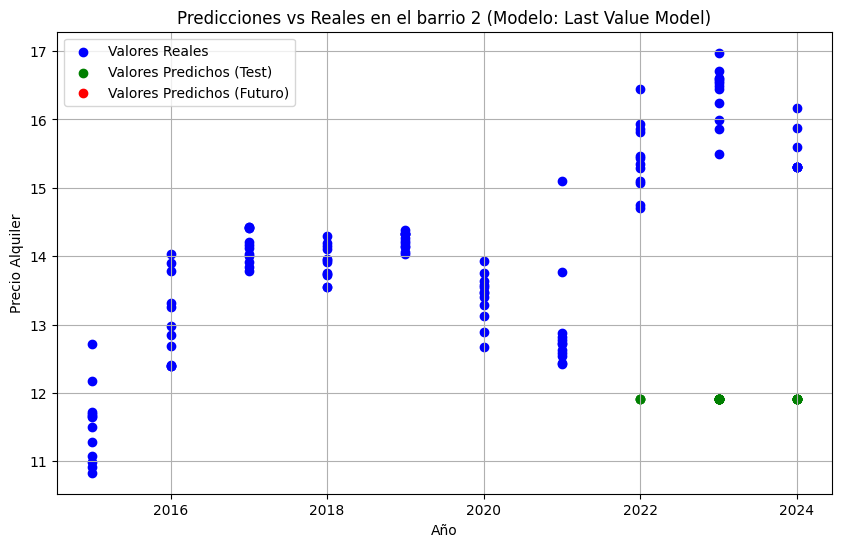

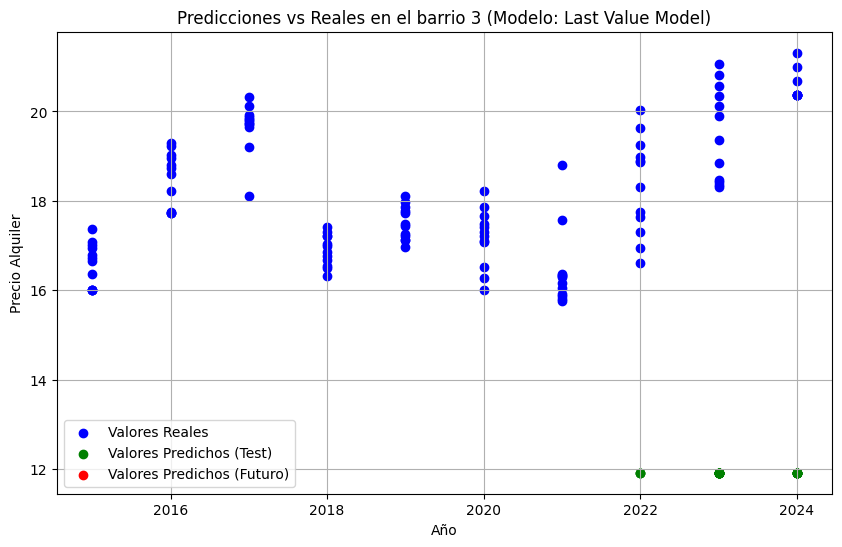

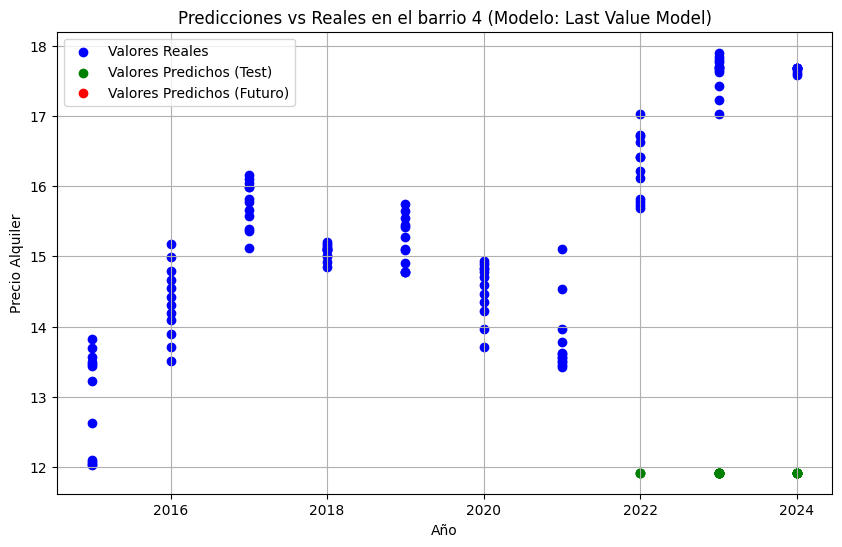

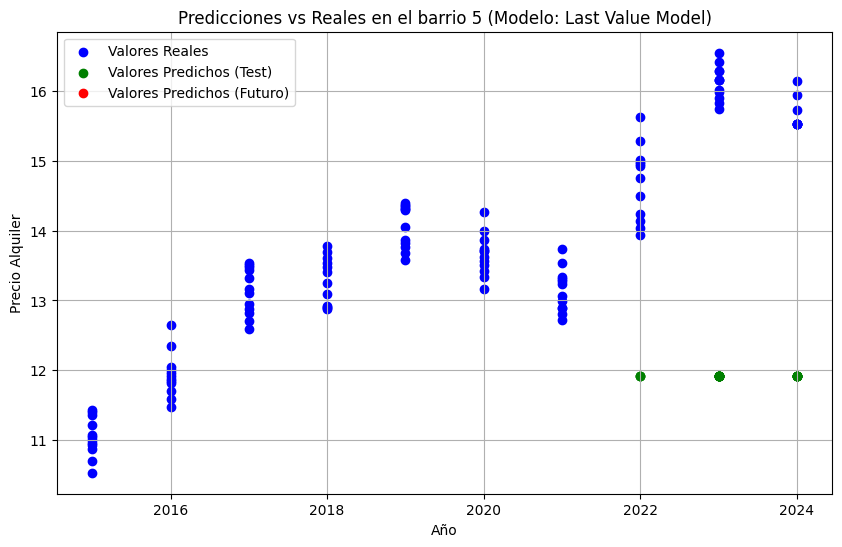

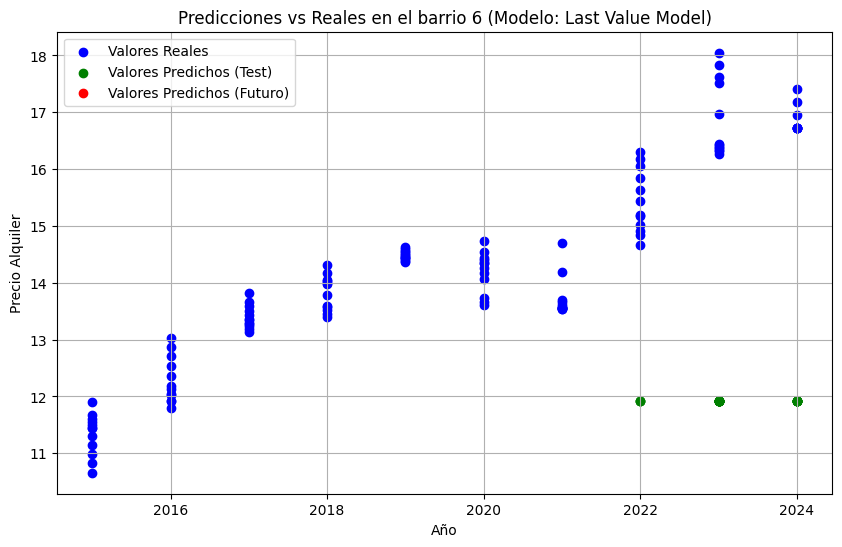

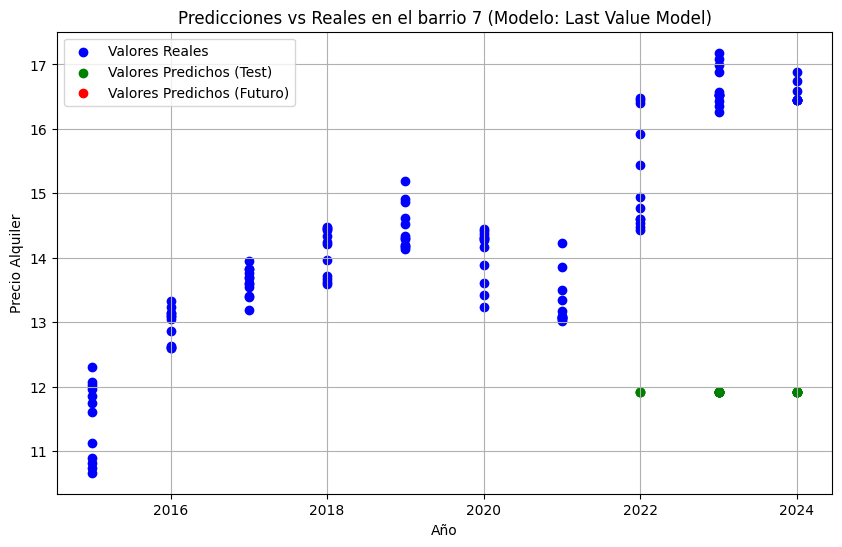

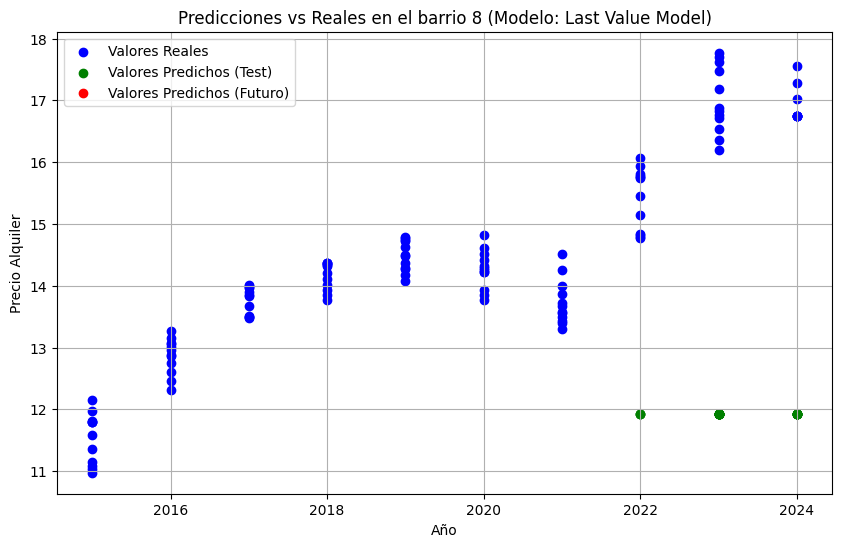

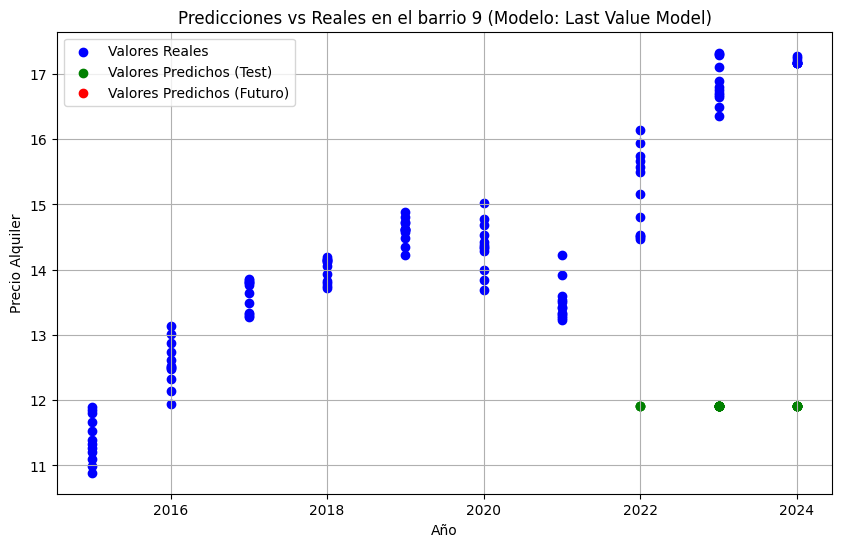

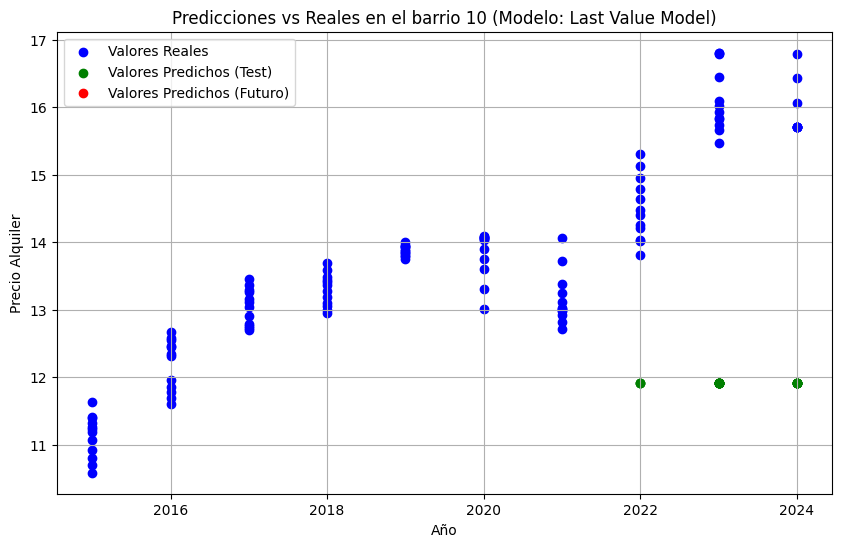

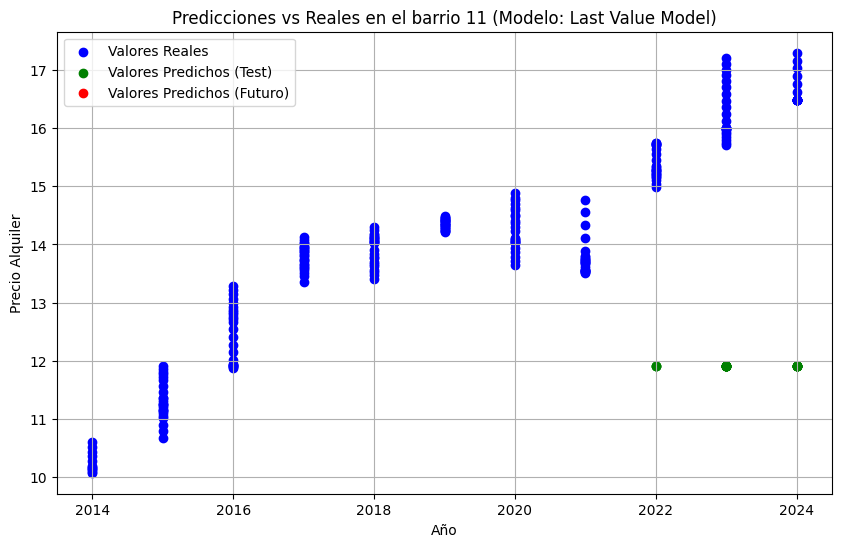

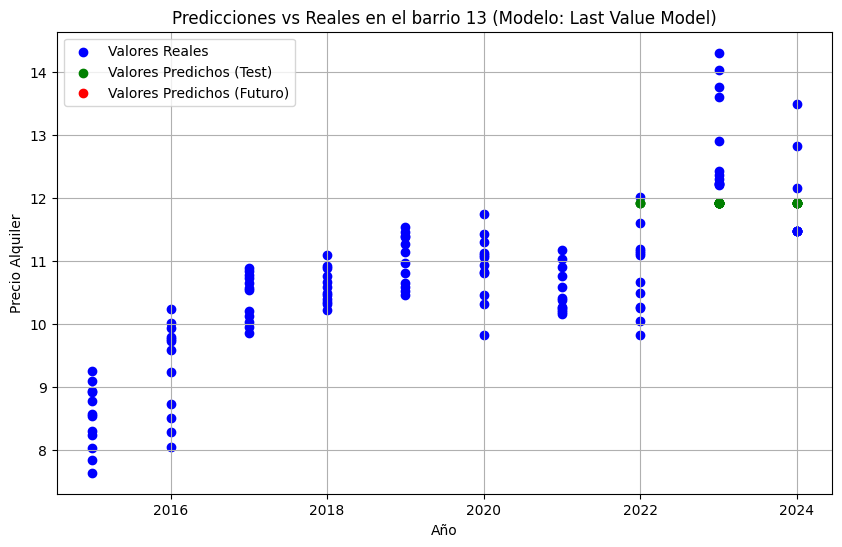

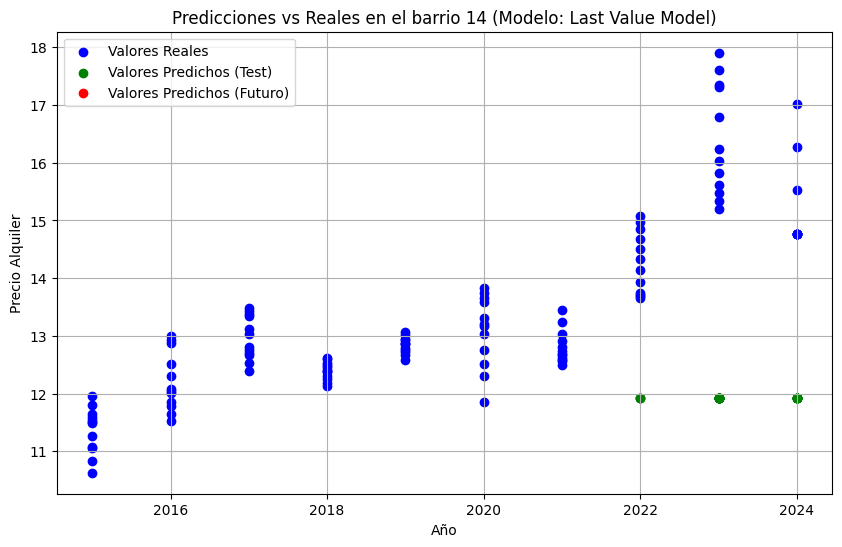

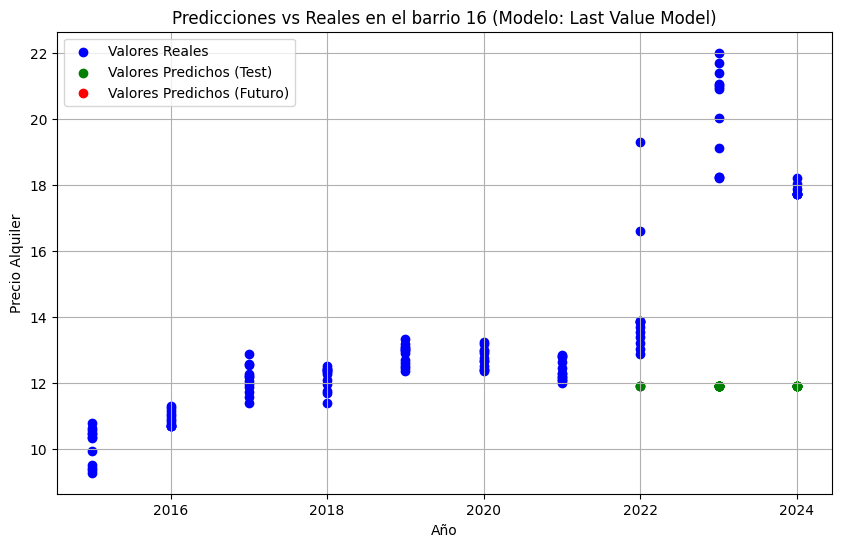

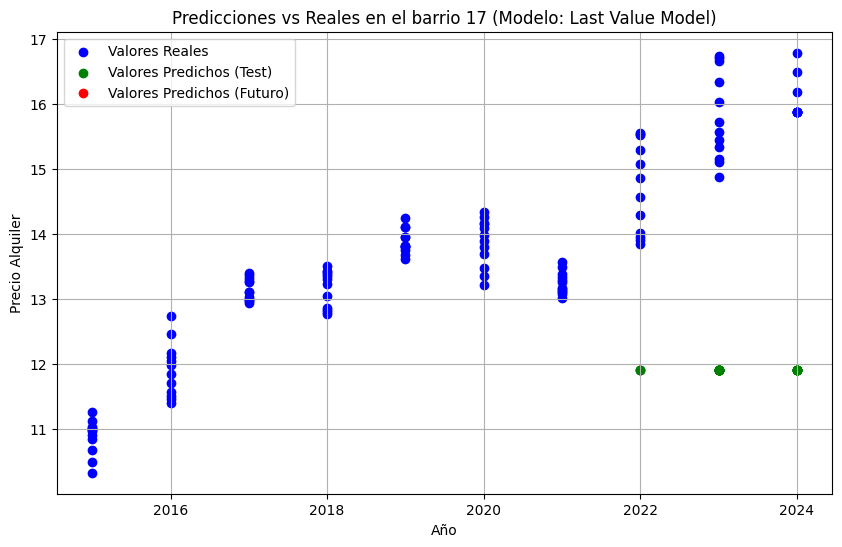

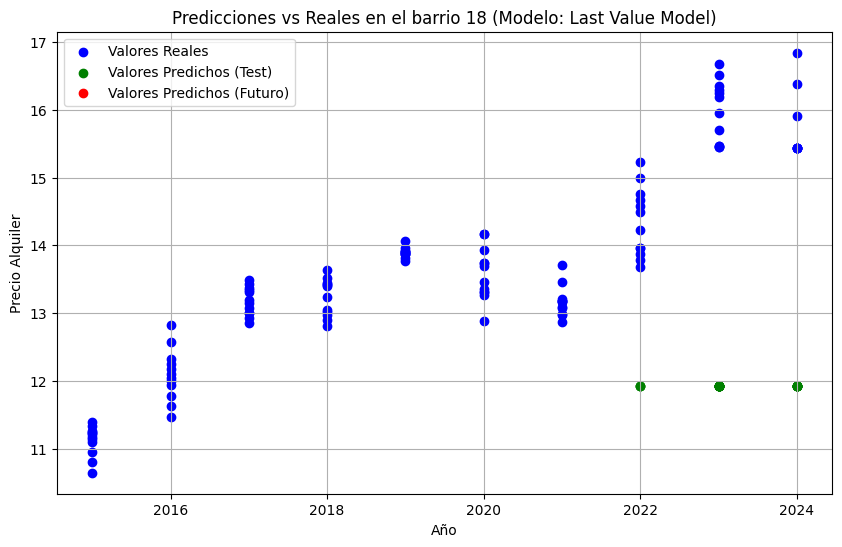

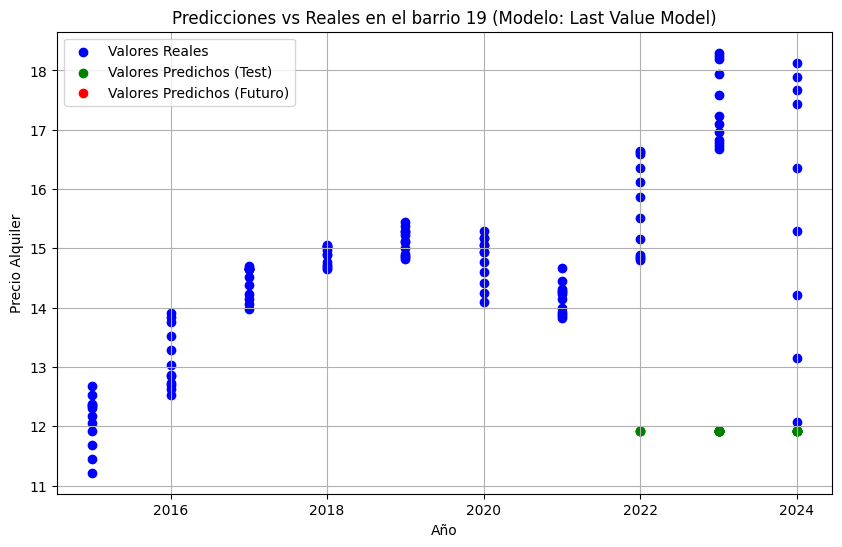

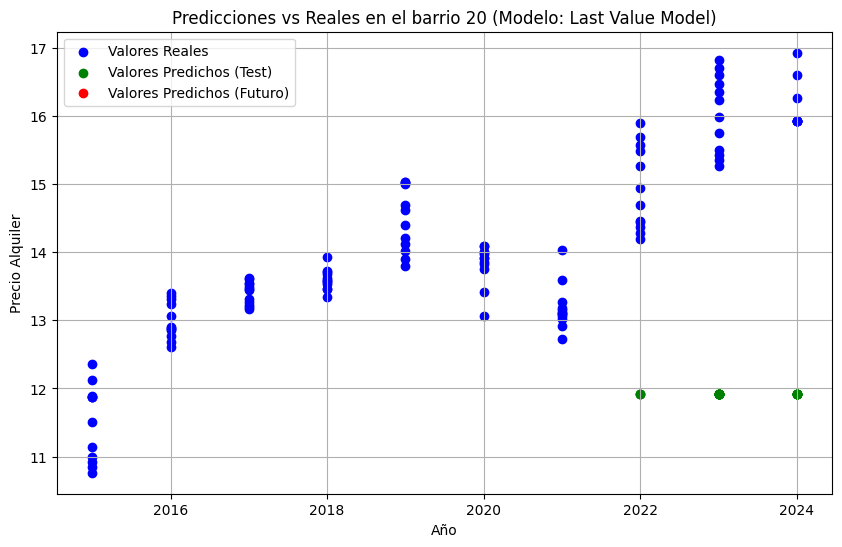

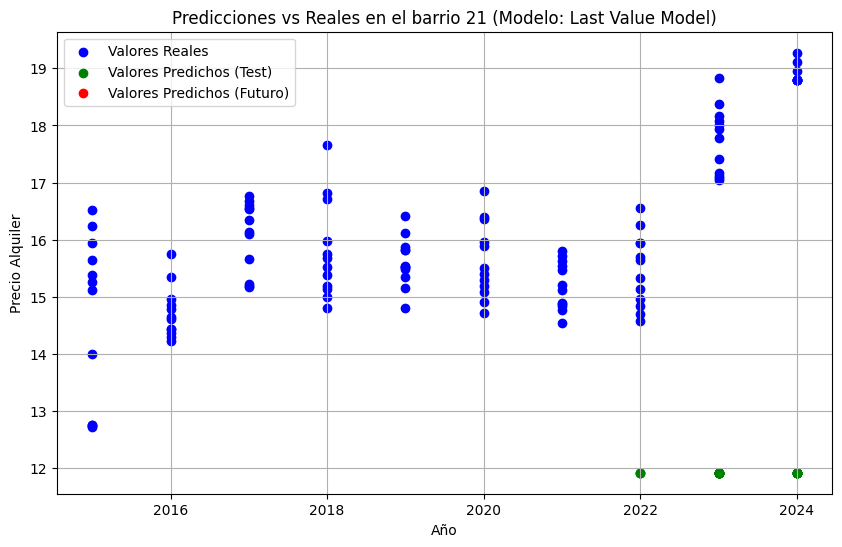

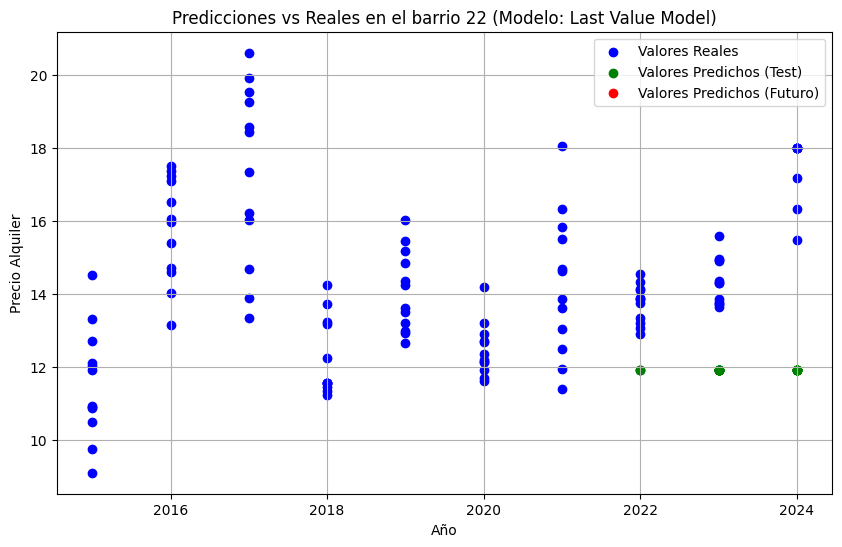

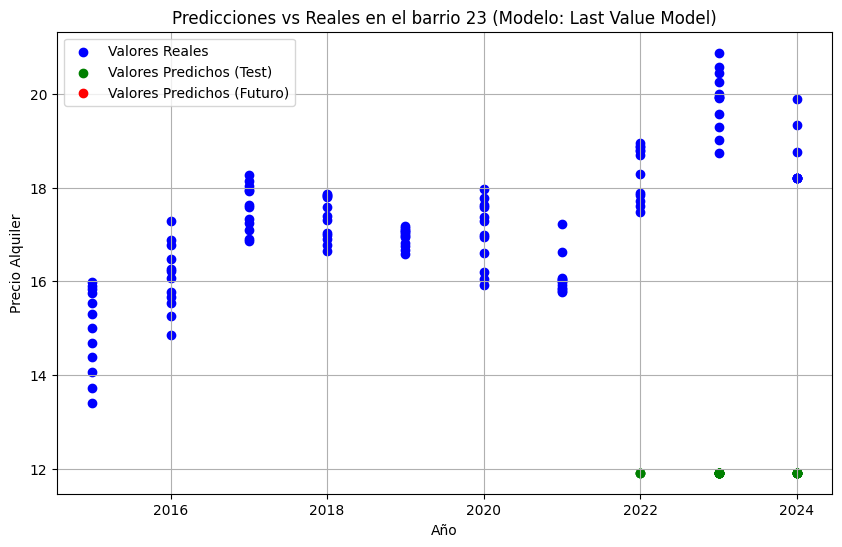

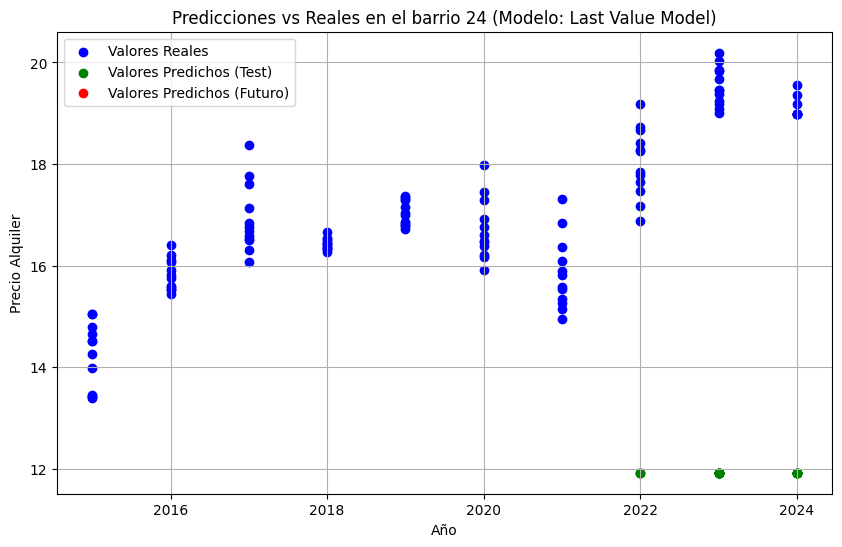

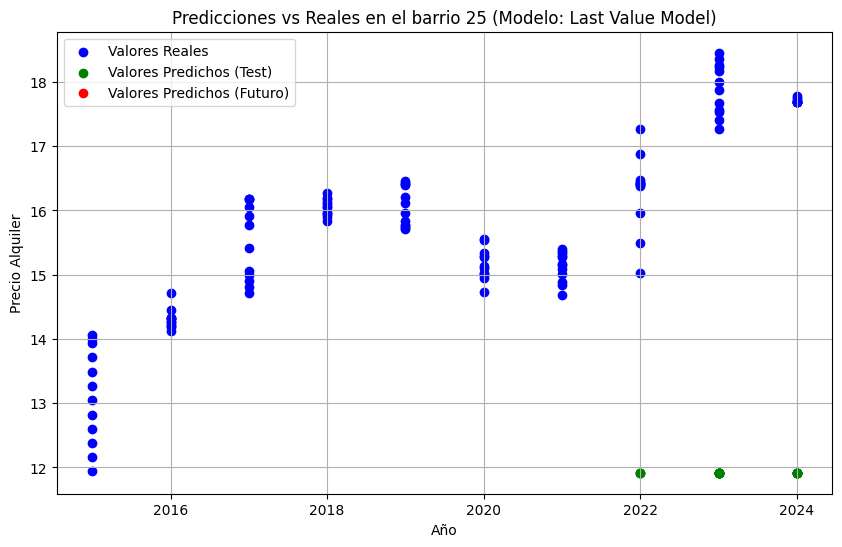

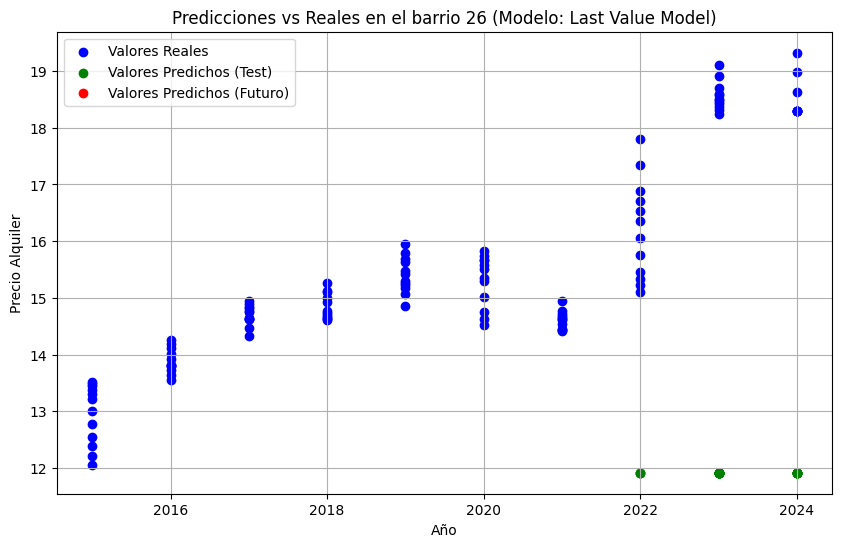

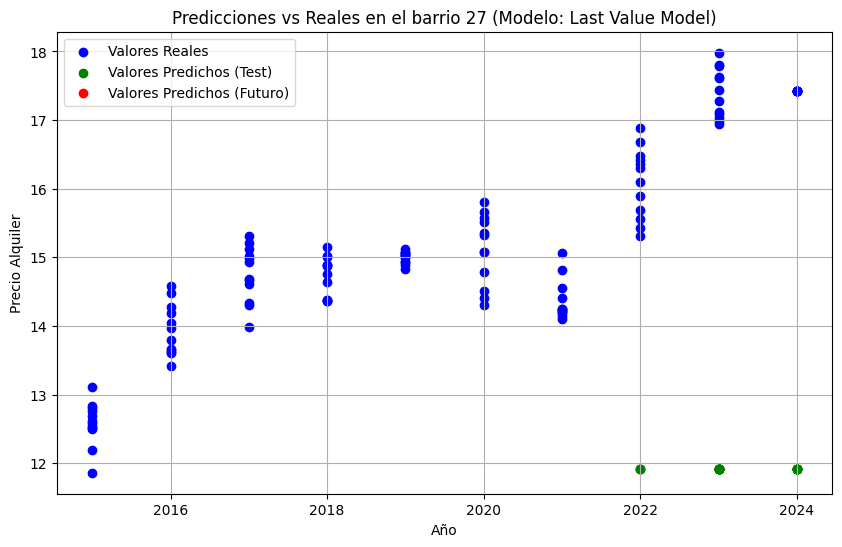

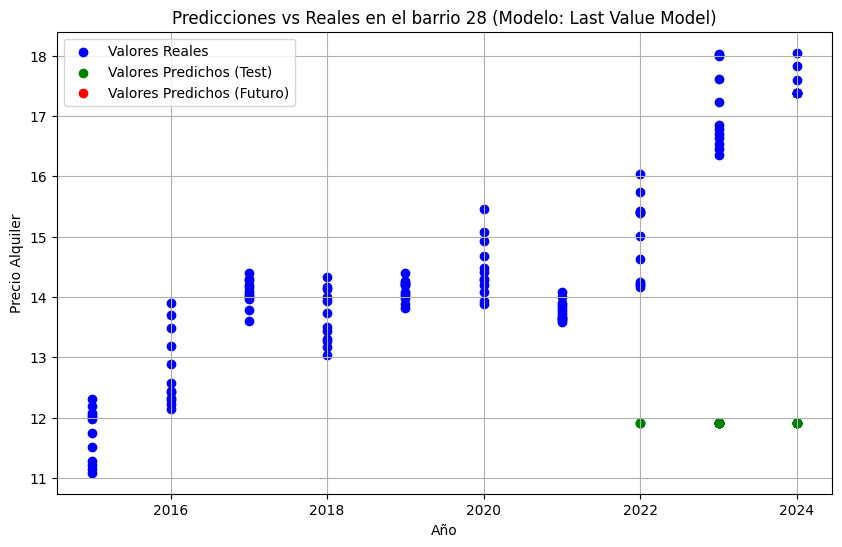

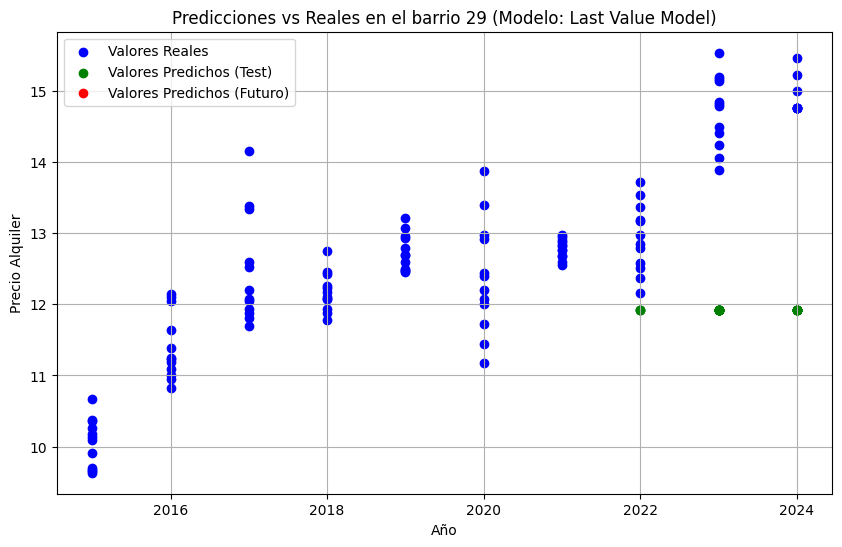

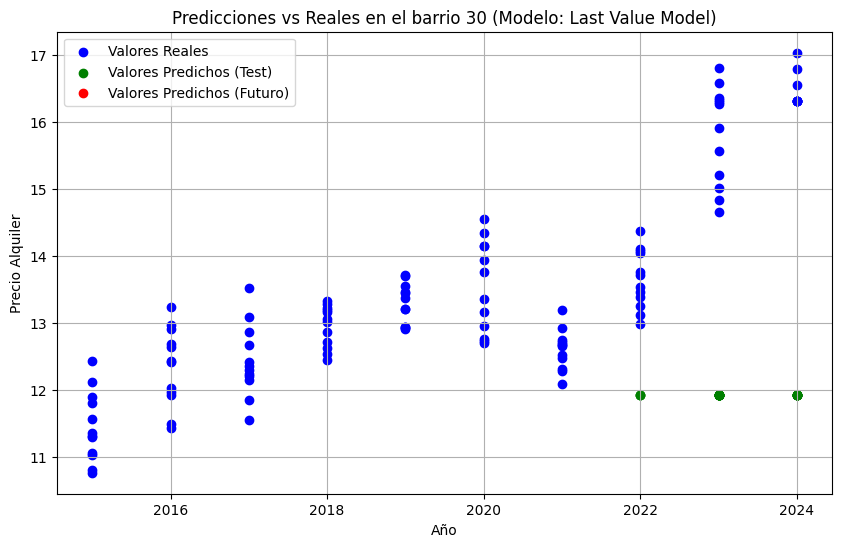

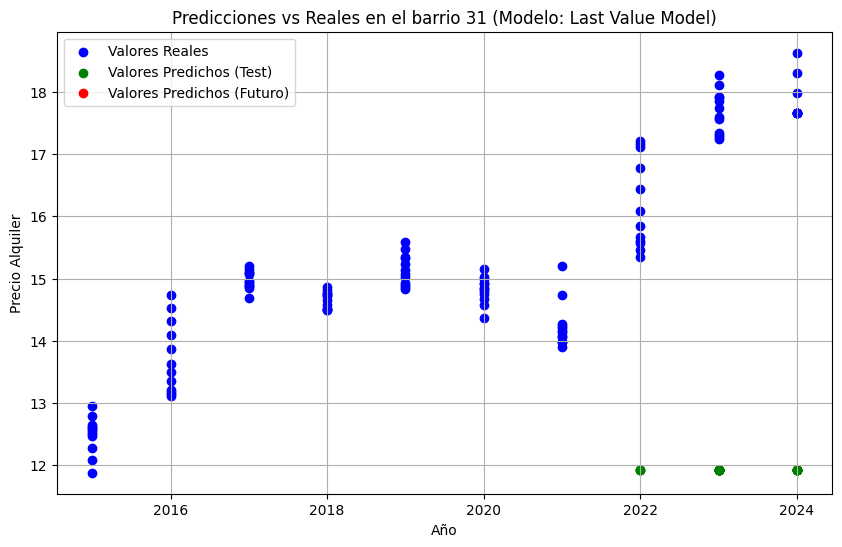

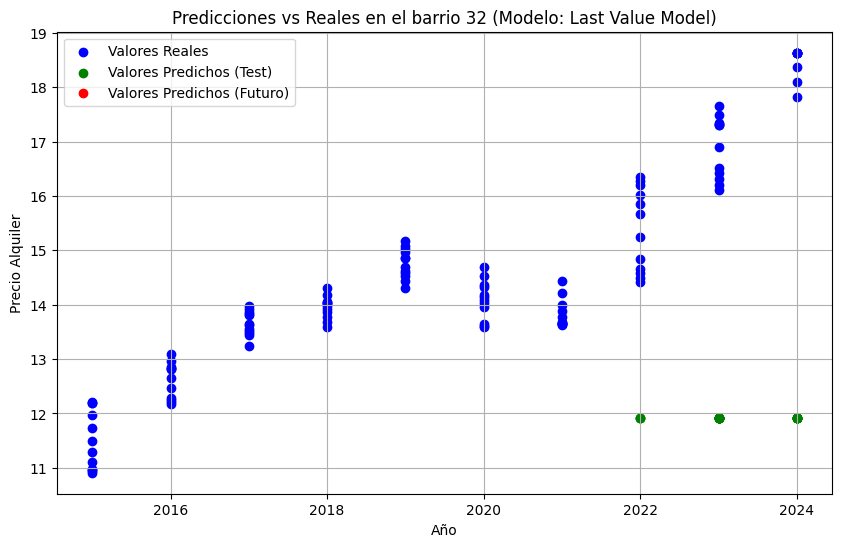

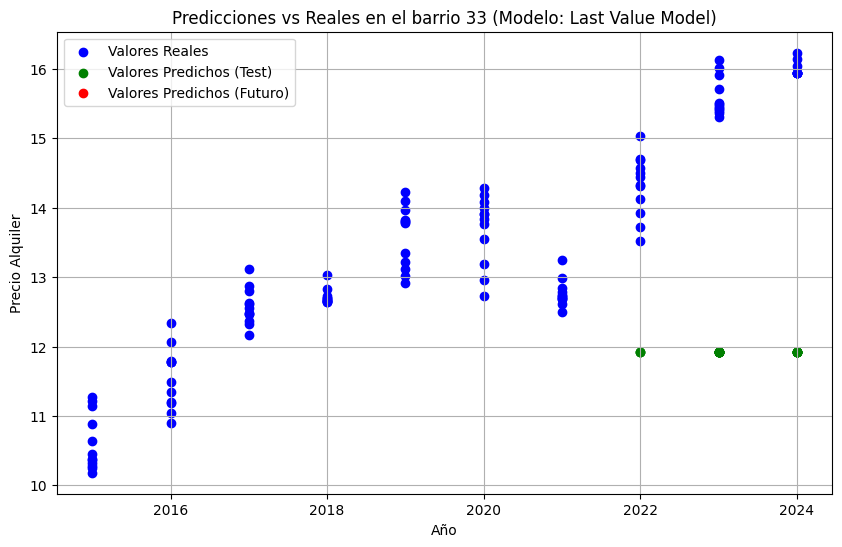

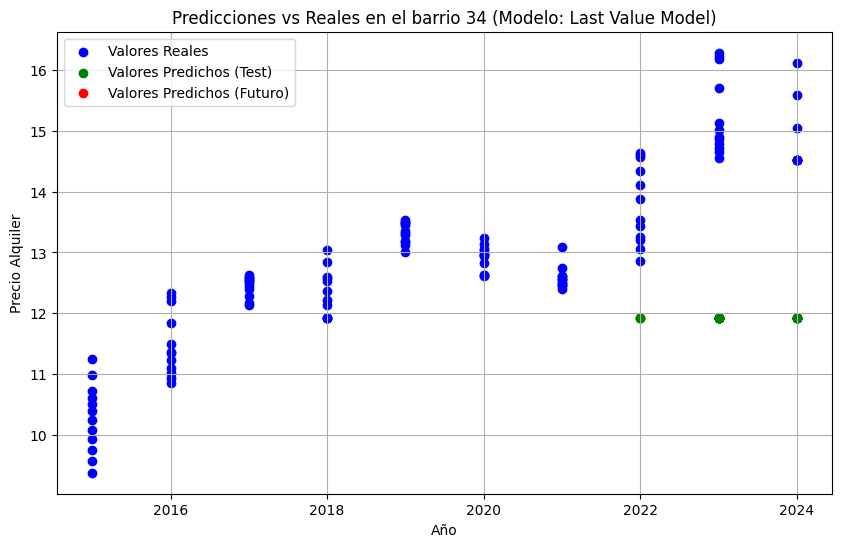

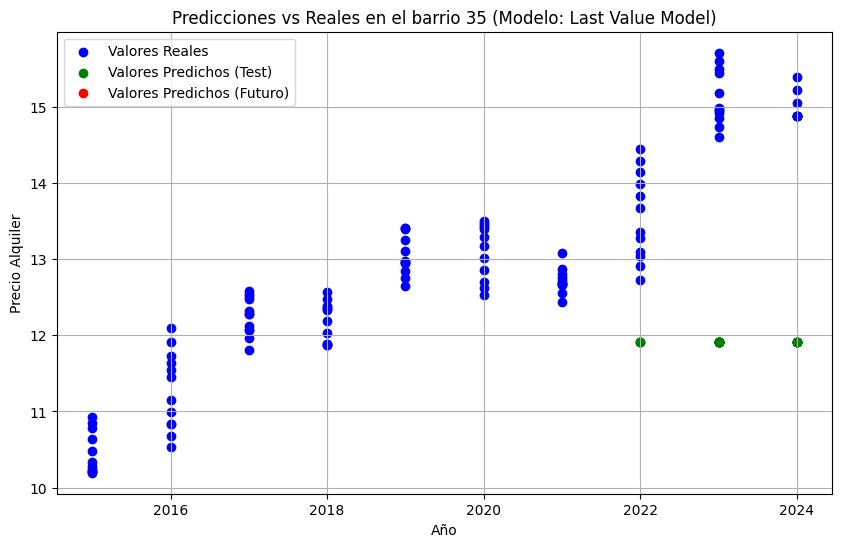

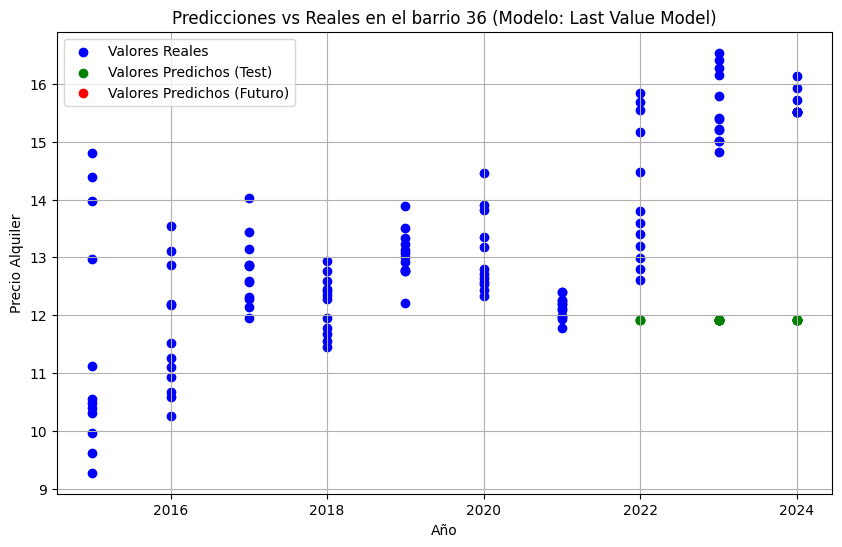

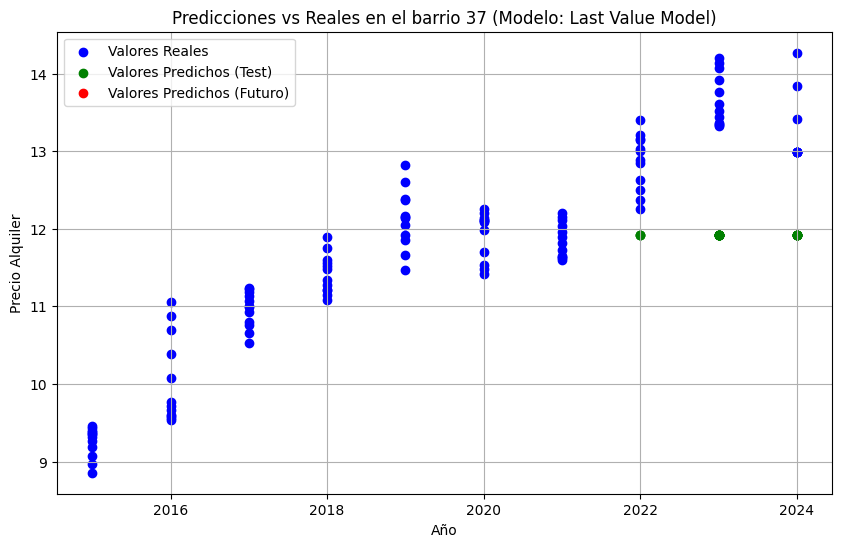

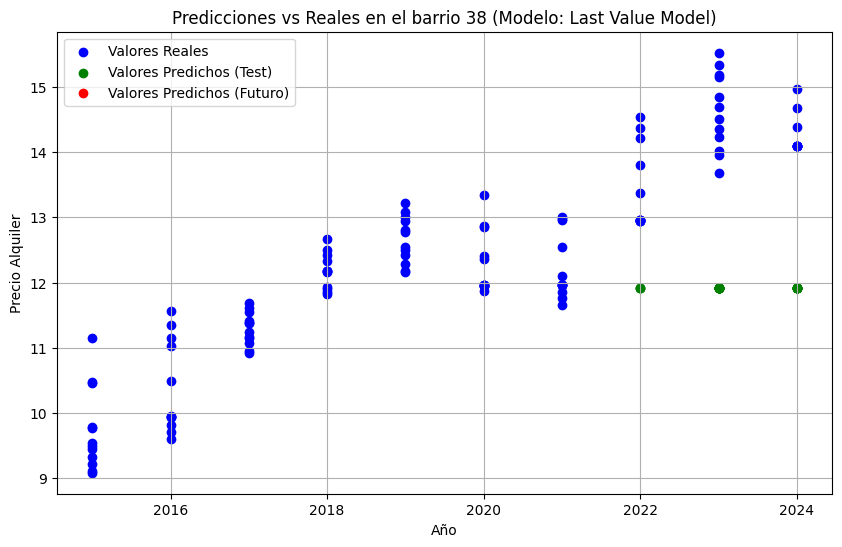

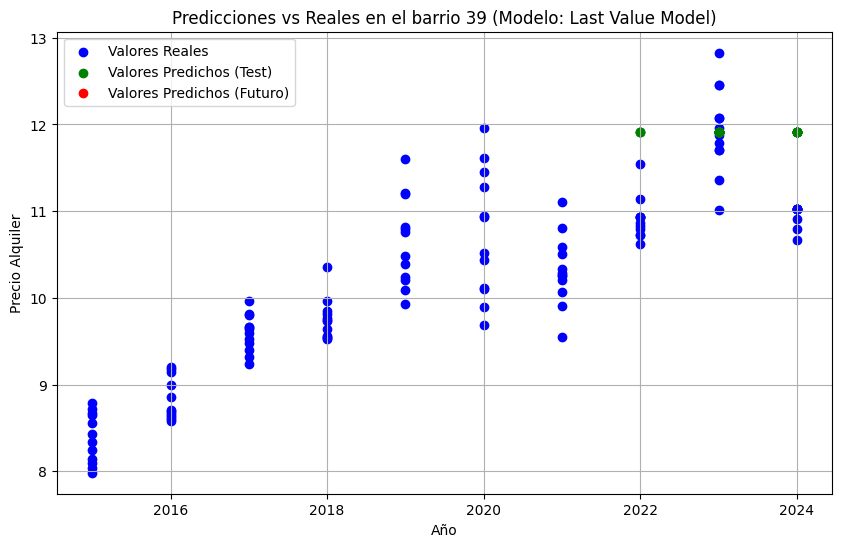

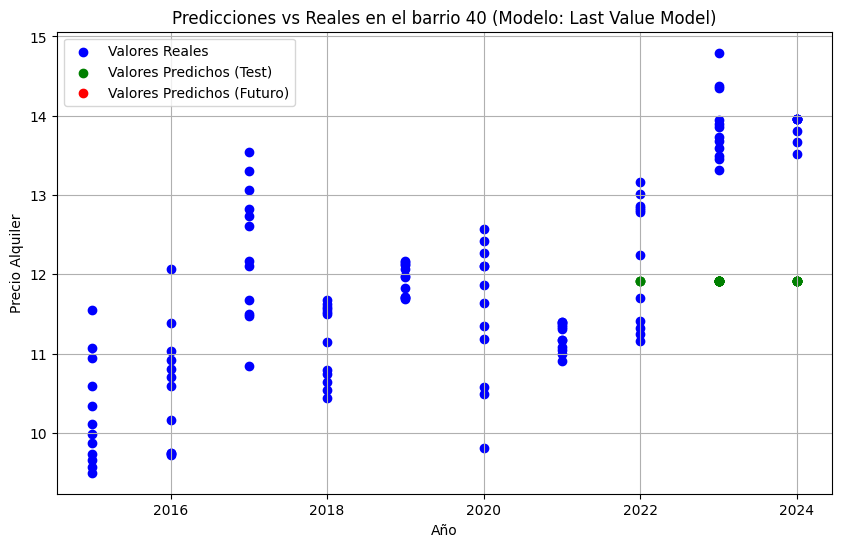

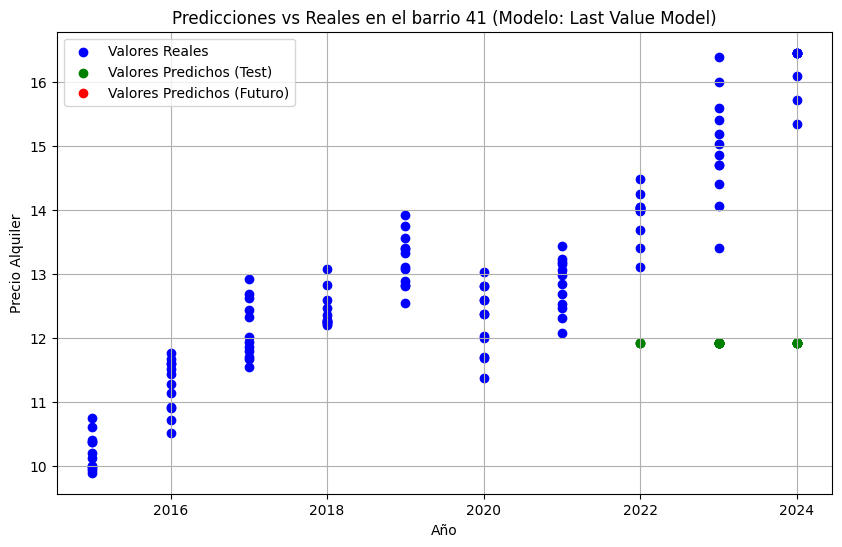

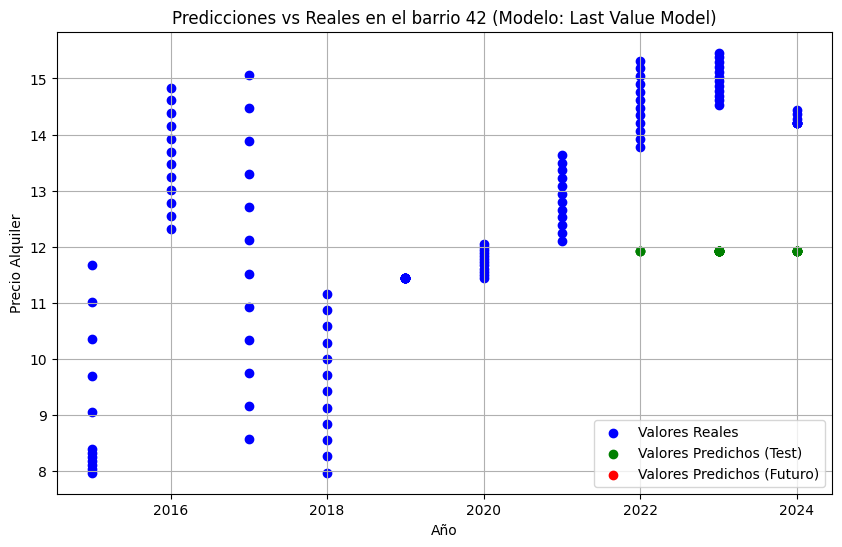

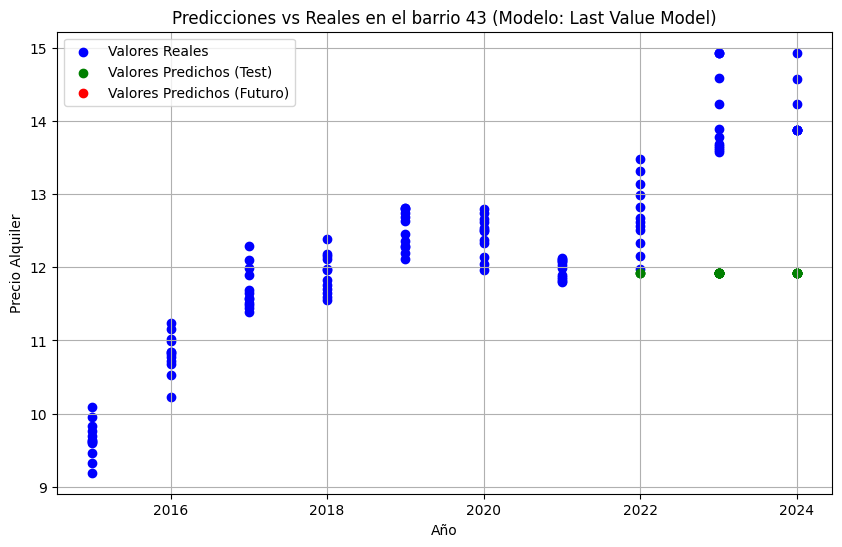

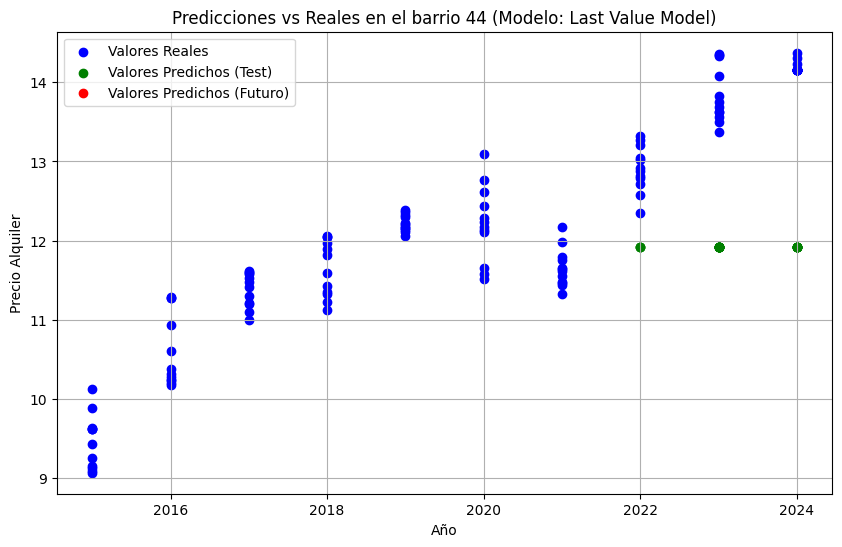

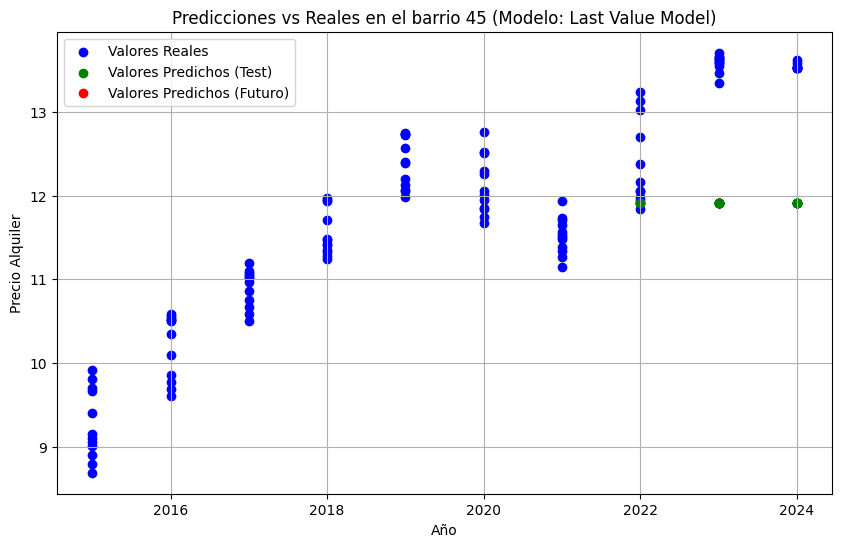

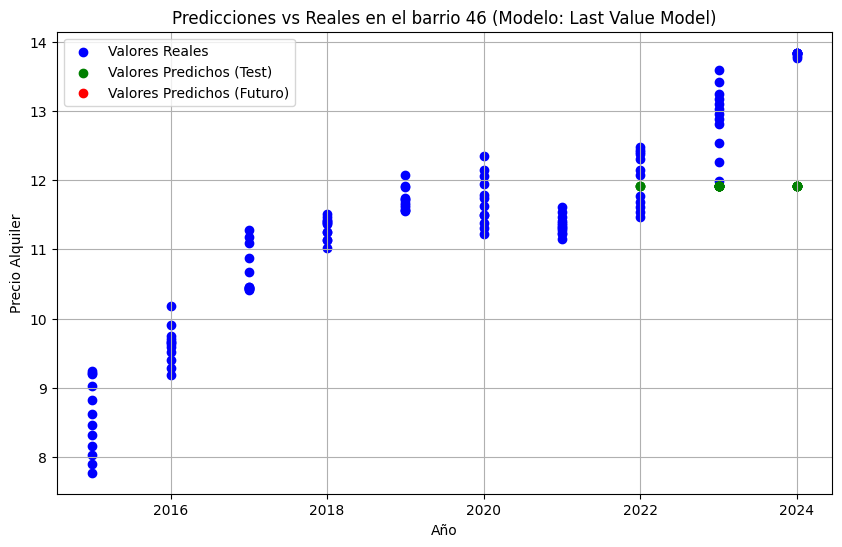

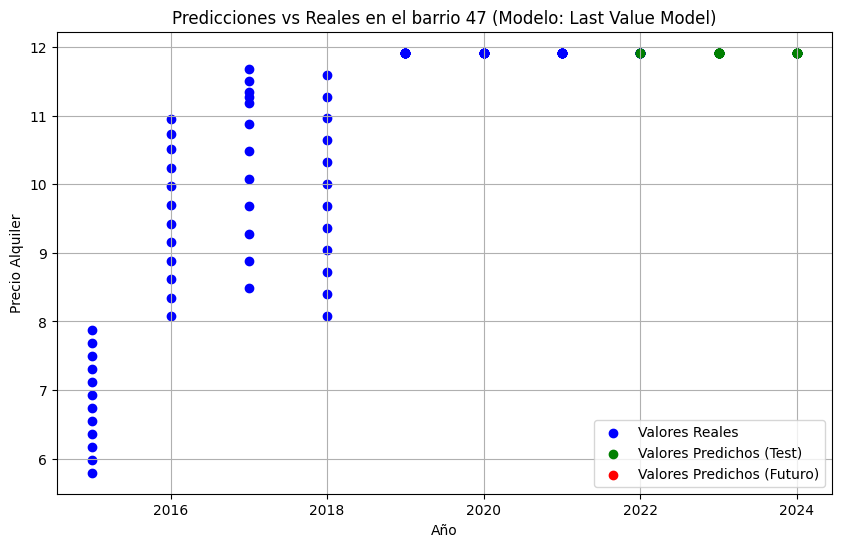

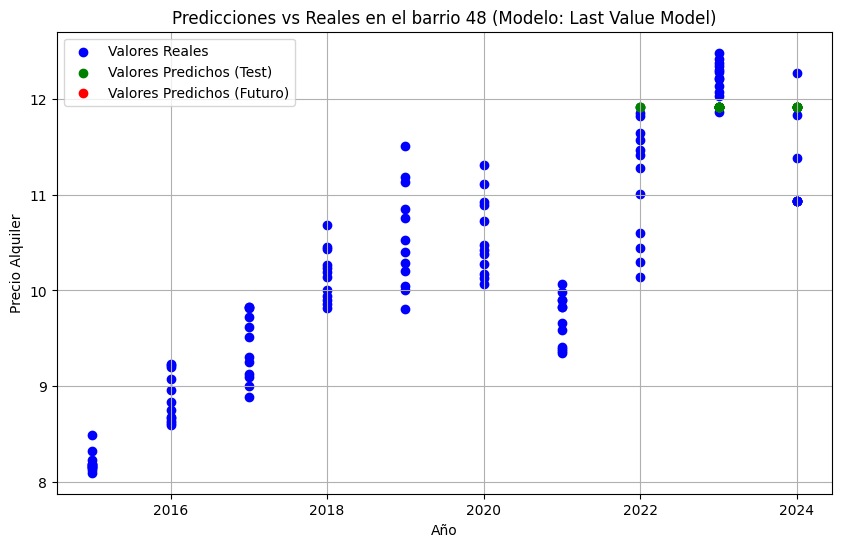

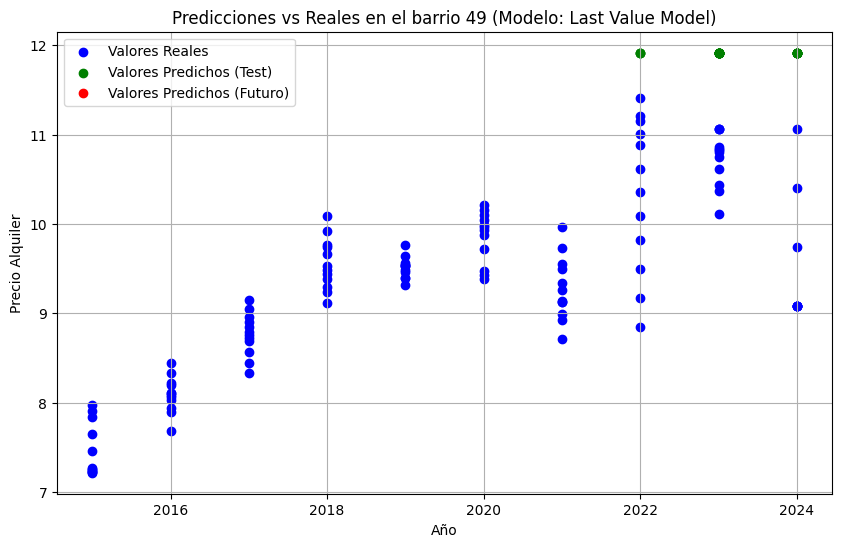

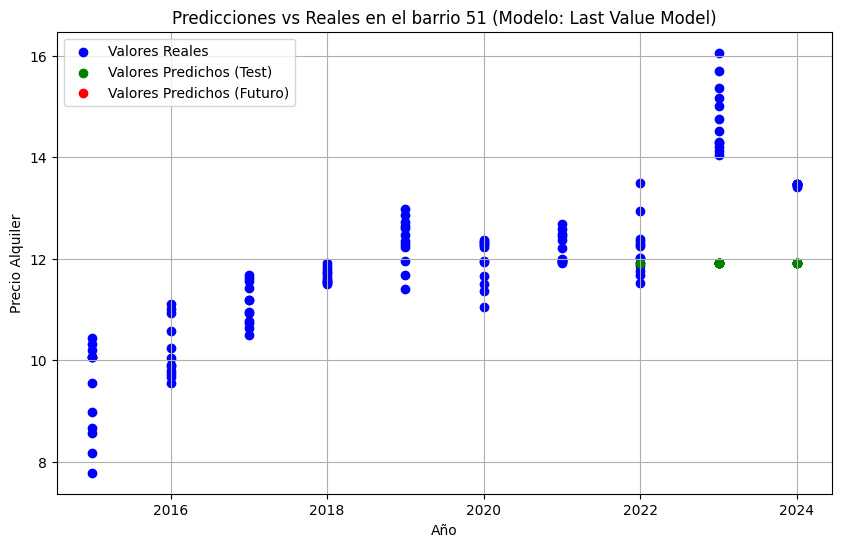

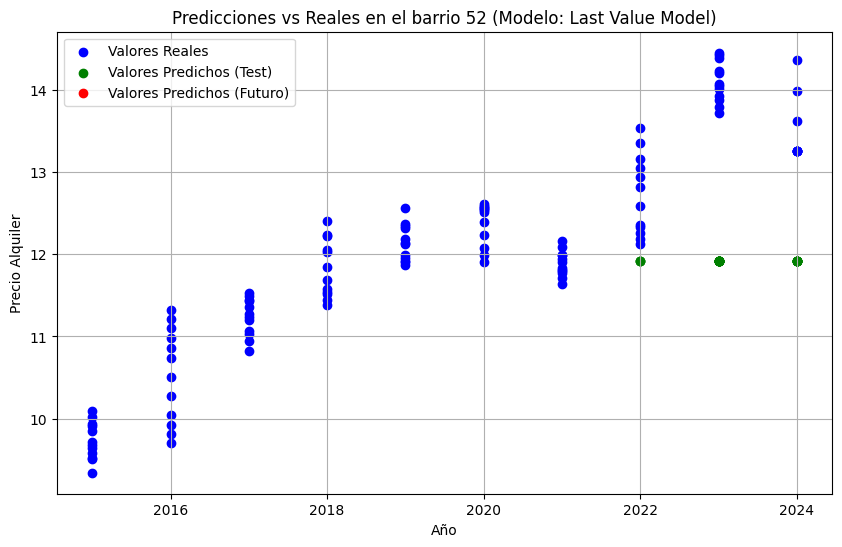

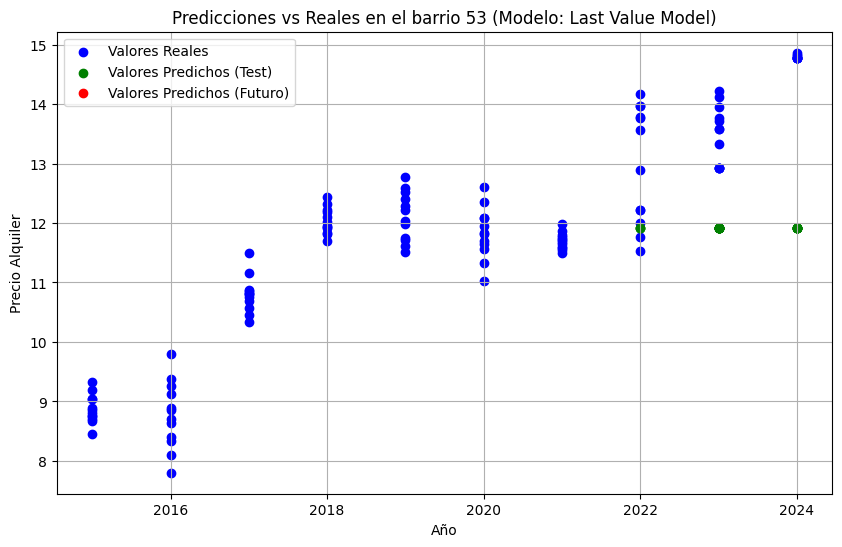

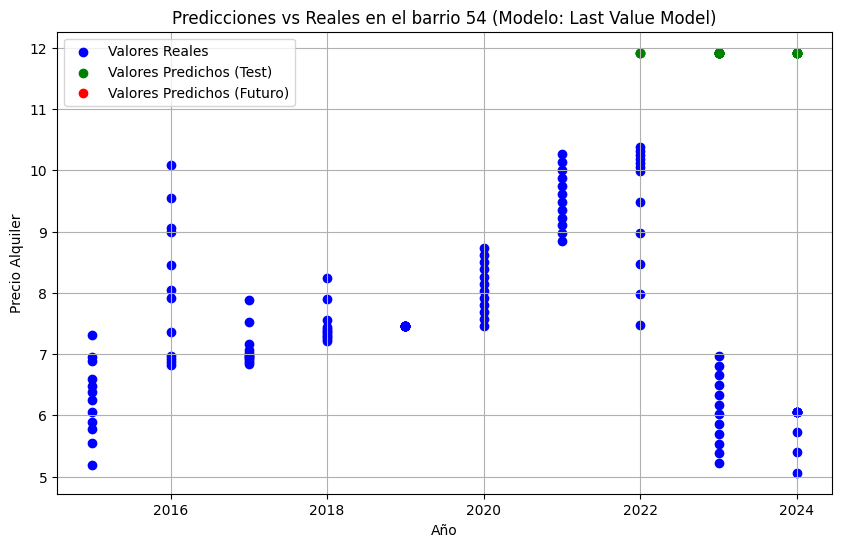

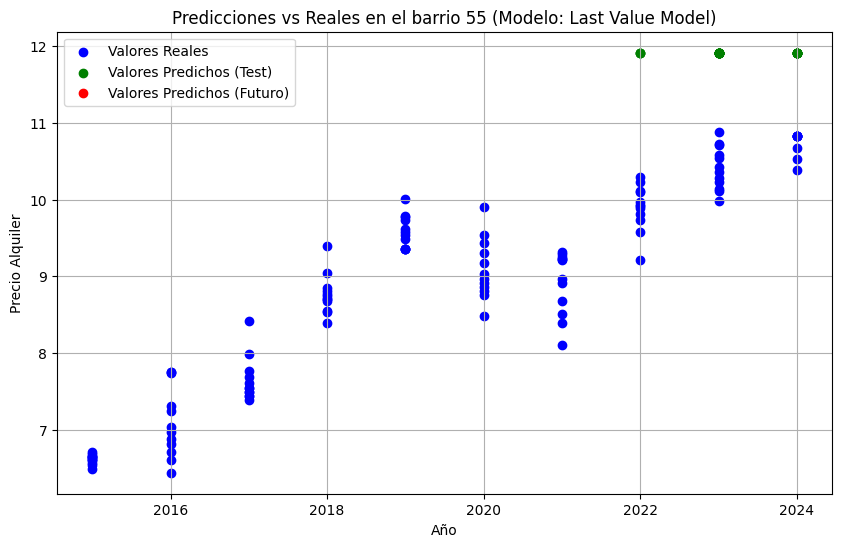

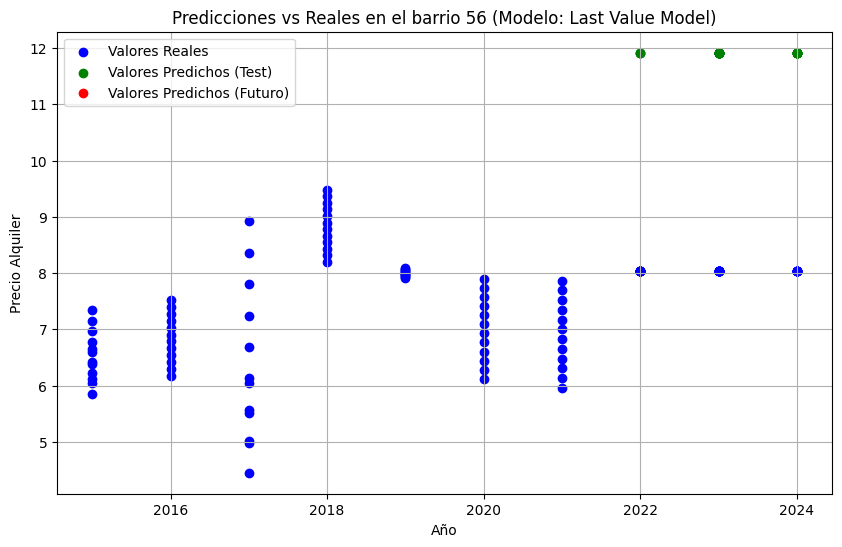

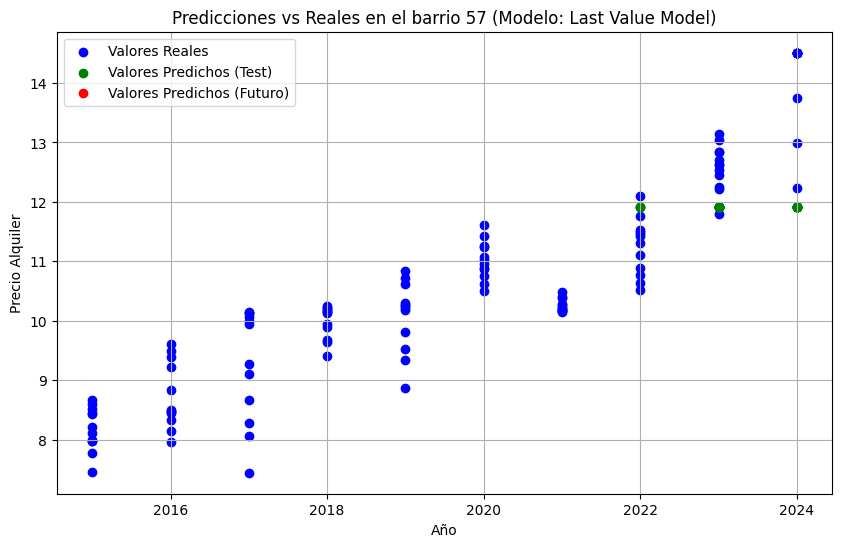

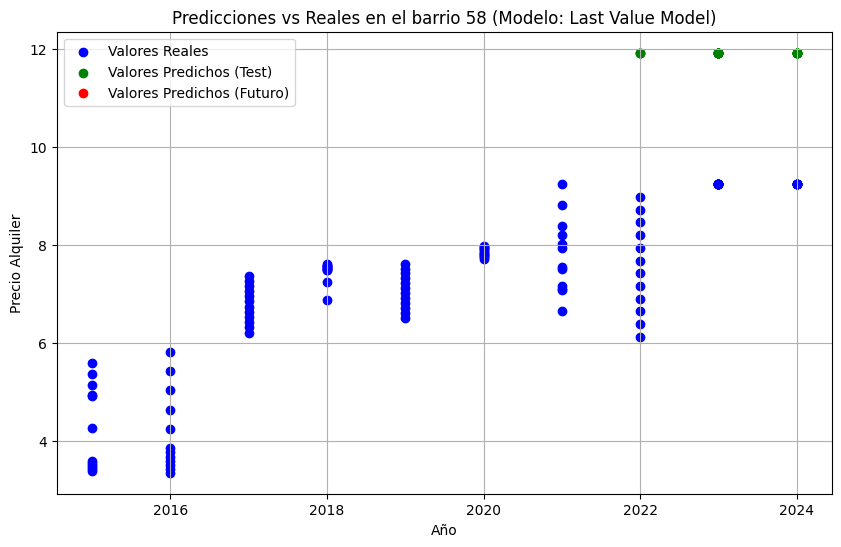

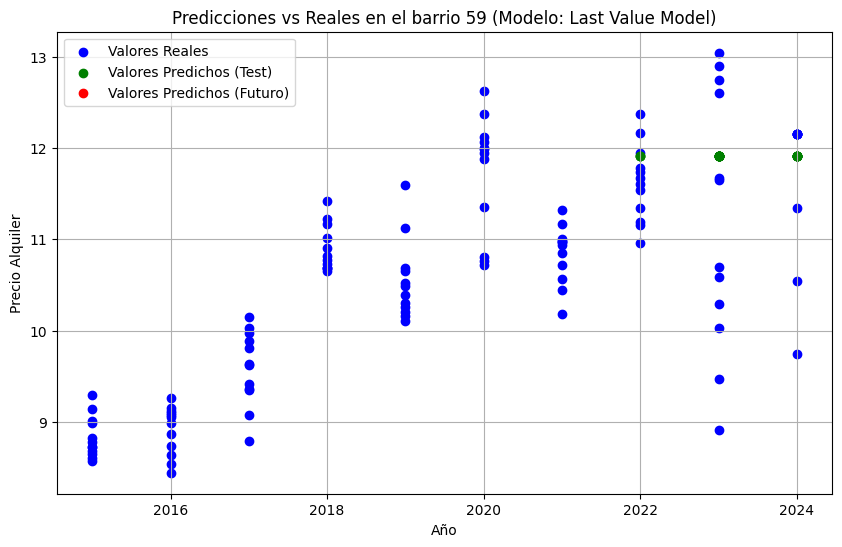

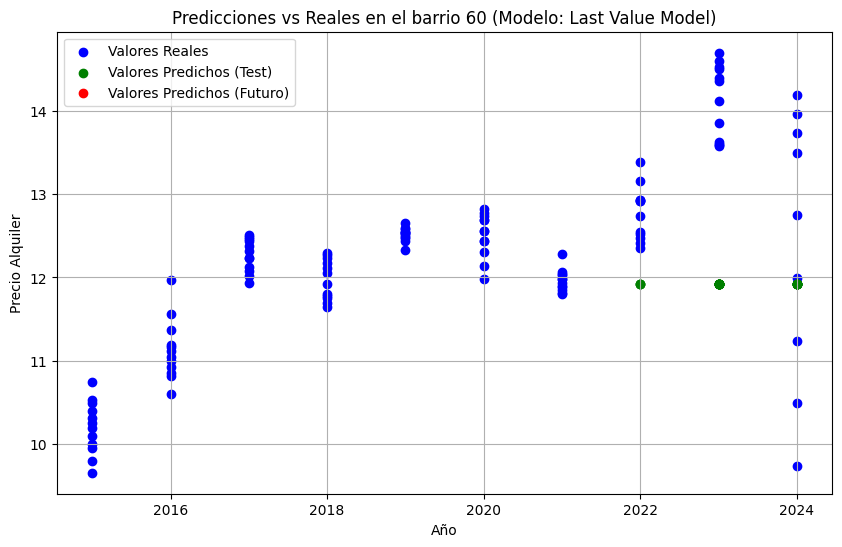

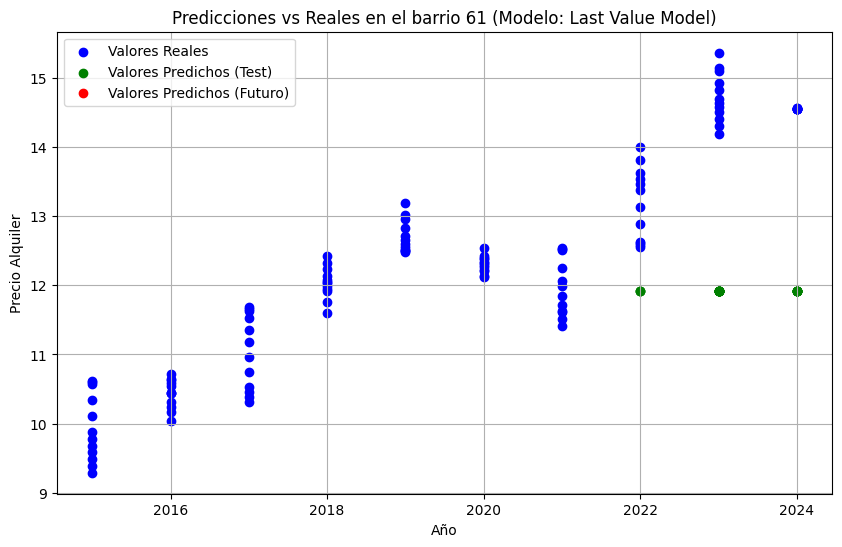

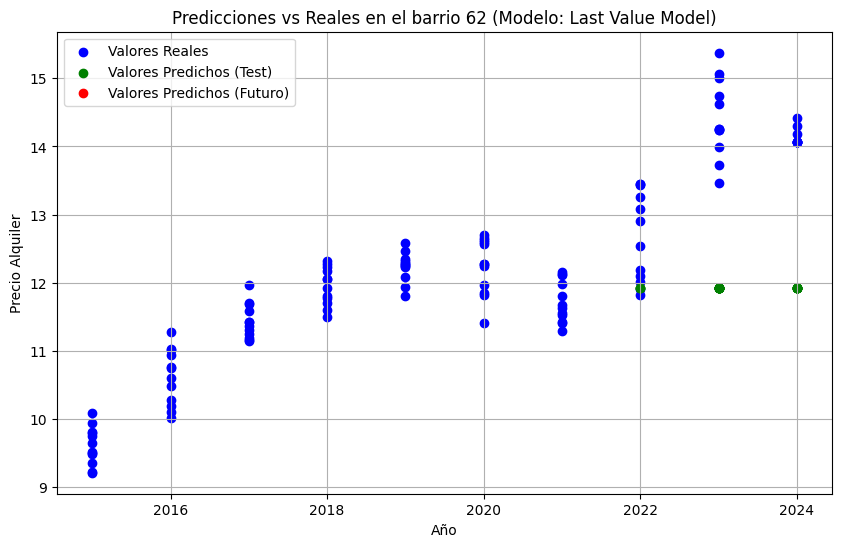

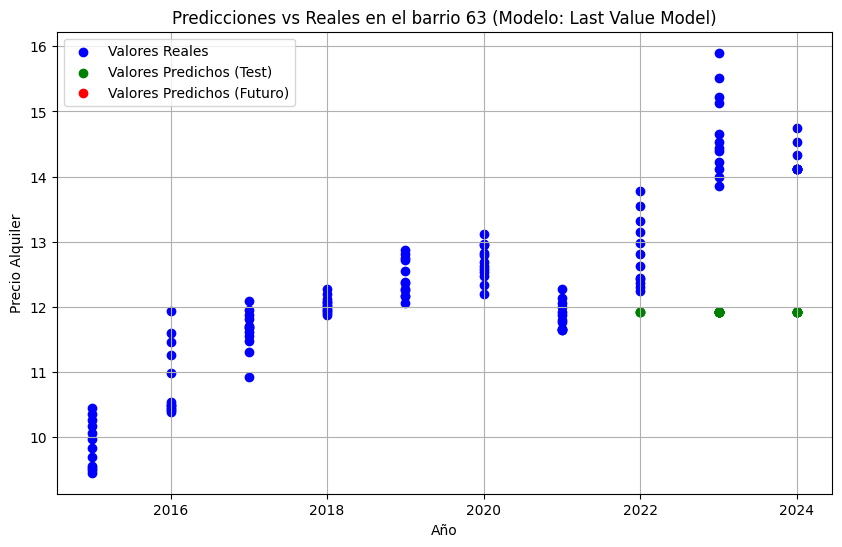

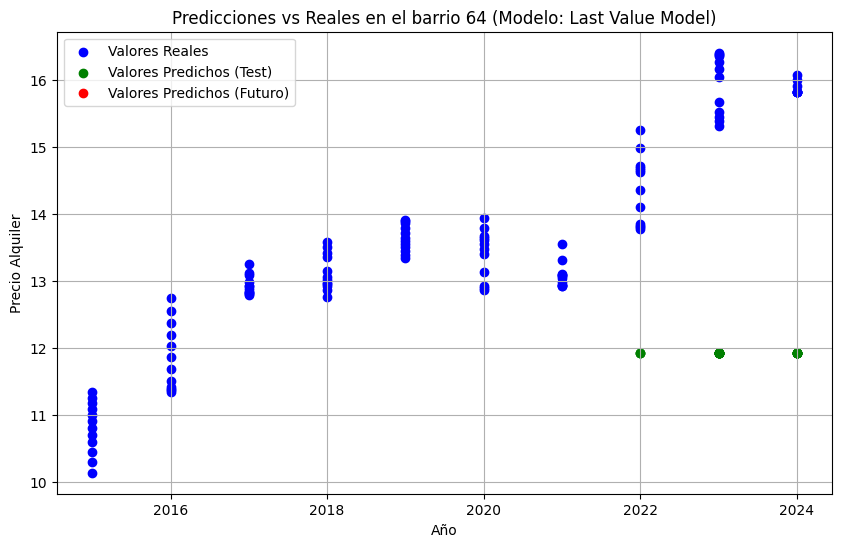

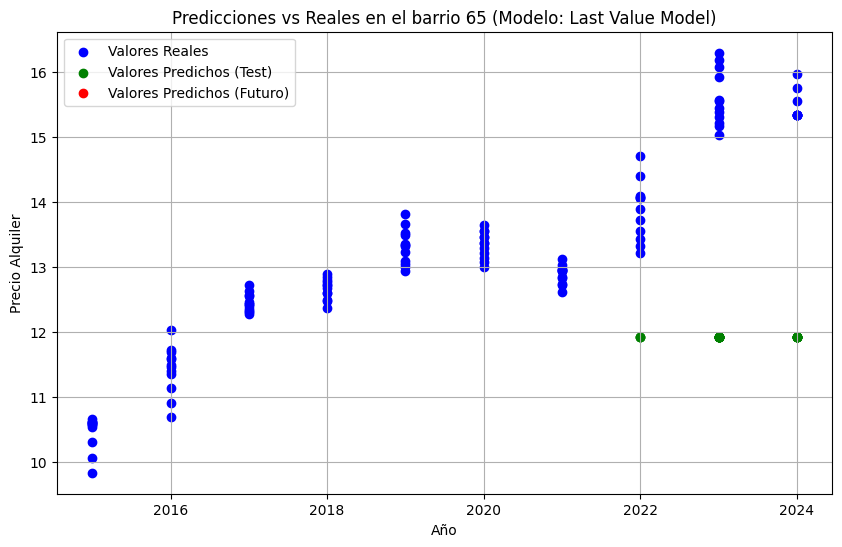

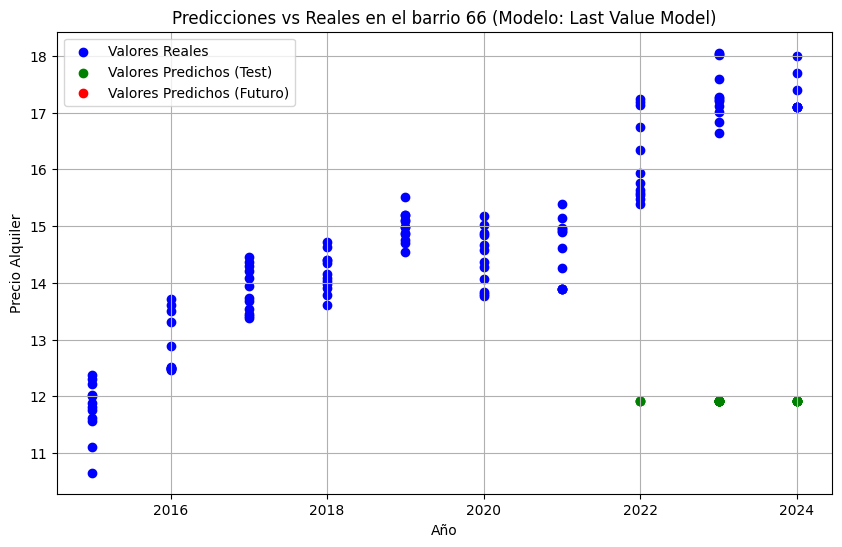

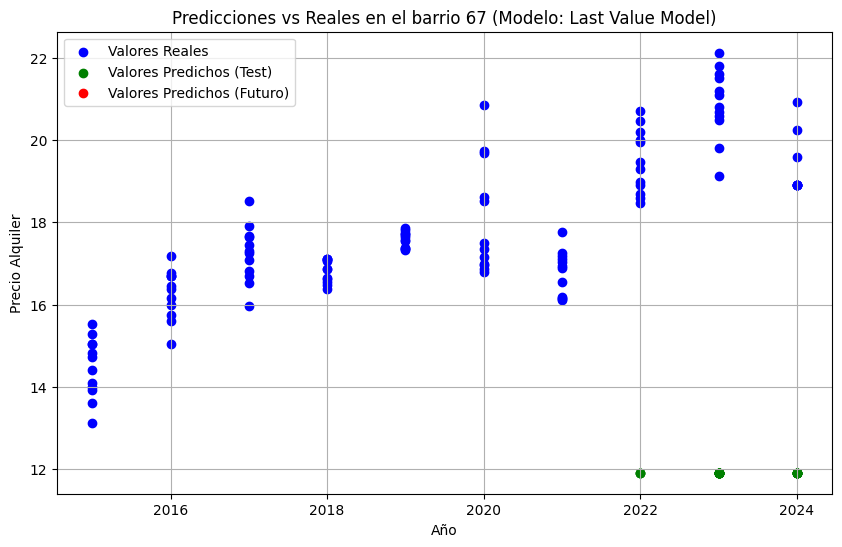

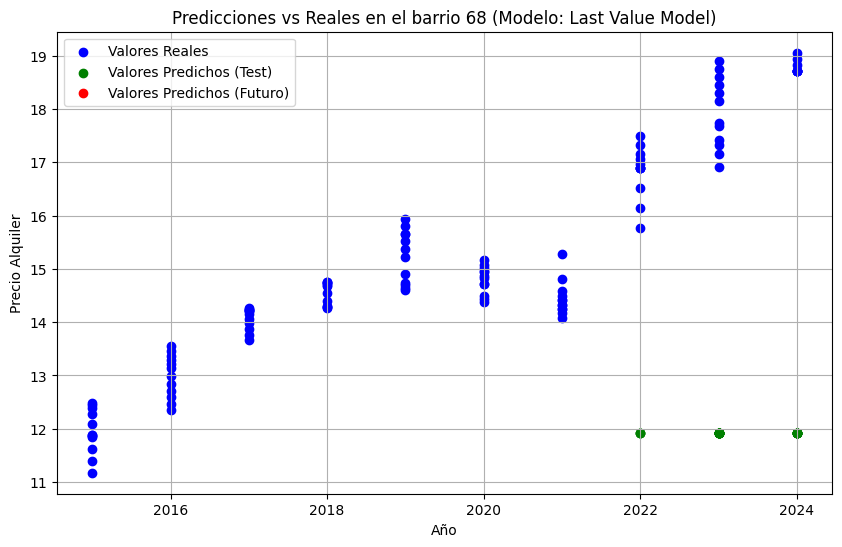

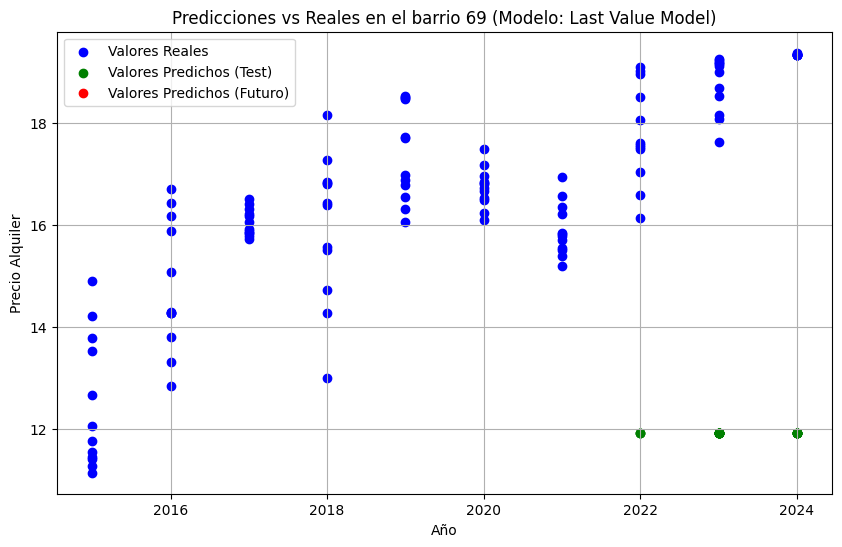

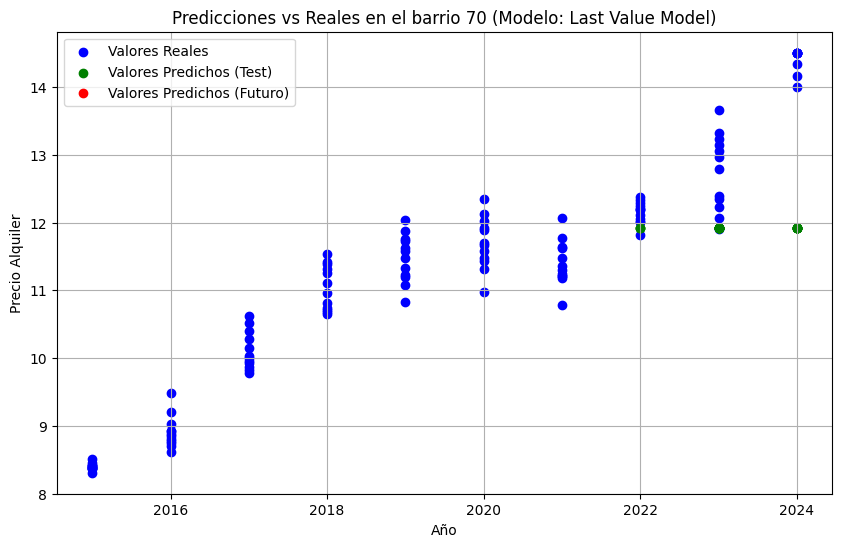

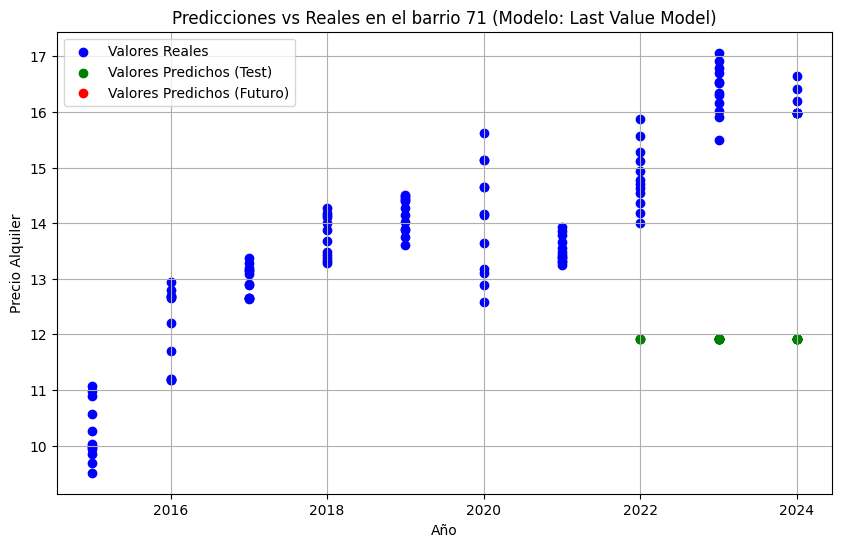

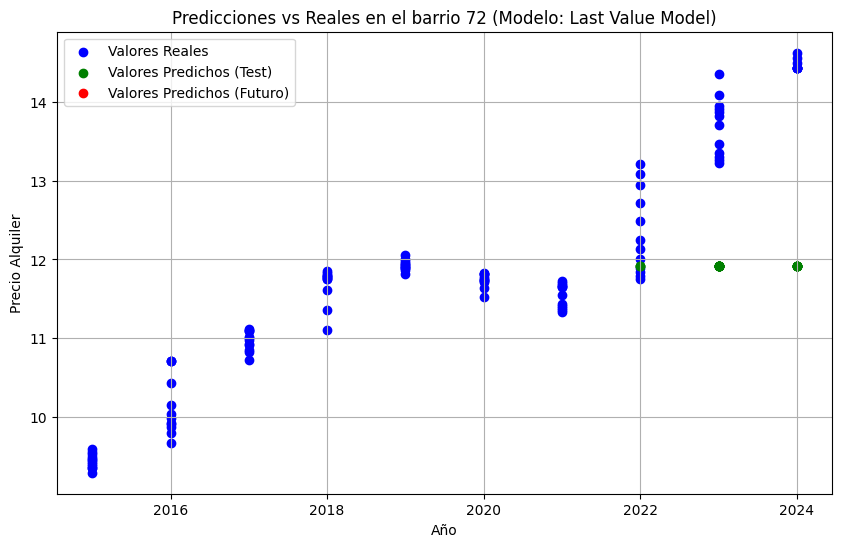

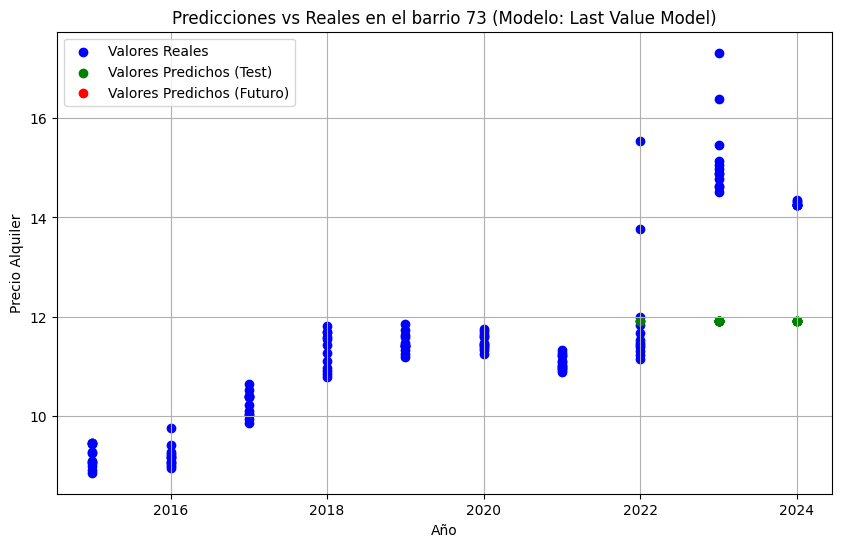


DataFrame con predicciones:
                   nombre  precio_alquiler  precio_venta  superficie_venta  \
5257  la verneda i la pau        16.384483   2388.916667         1660.0000   
5258  la verneda i la pau        15.449696   2328.882353         1656.0625   
5259  la verneda i la pau        14.514910   2318.080000         1652.1250   
5260  la verneda i la pau        14.640991   2053.777778         1648.1875   
5261  la verneda i la pau        14.767073   1712.000000         1644.2500   
5262  la verneda i la pau        14.893154   2872.117647         1640.3125   
5263  la verneda i la pau        14.973521   1815.285714         1636.3750   
5264  la verneda i la pau        15.053888   2136.461538         1632.4375   
5265  la verneda i la pau        15.134255   2321.600000         1628.5000   
5266  la verneda i la pau        14.875601   2114.235294         1624.5625   
5267  la verneda i la pau        14.616948   2483.421053         1620.6250   
5268  la verneda i la pau        14

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings("ignore")
from prophet import Prophet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import joblib
import time
import os


# Cargar el DataFrame procesado
bcn_precios_encoded = pd.read_csv('bcn_precios_processed.csv')

# 1. Funciones de Validación y Métricas

def timeseries_train_test_split(data, train_size=0.8):
    """Divide un DataFrame en conjuntos de entrenamiento y prueba para series temporales."""
    train_index = int(len(data) * train_size)
    train_data = data.iloc[:train_index]
    test_data = data.iloc[train_index:]
    return train_data, test_data


def evaluate_model(y_true, y_pred):
    """Evalúa el modelo utilizando RMSE, MAE, MAPE y R2."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2


def plot_predictions(y_true, y_pred, title='Predicciones vs Reales'):
    """Genera un gráfico scatterplot de las predicciones vs los valores reales."""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel('Valores Reales')
    plt.ylabel('Valores Predichos')
    plt.title(title)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')  # Línea de referencia
    plt.grid(True)
    plt.show()

# 2. Funciones de Modelado

def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, params=None, model_path=None):
    """Entrena, evalúa y realiza predicciones con un modelo."""
    start_time = time.time()
    if model_path and os.path.exists(model_path):
          print(f"Cargando modelo previamente entrenado {model_name}...")
          best_model = joblib.load(model_path)
    else:
        print(f"Entrenando modelo {model_name}...")
        if params:
            model = RandomizedSearchCV(model, params, cv=3, scoring='neg_mean_squared_error', n_iter=5,random_state=42)
            model.fit(X_train, y_train)
            best_model = model.best_estimator_
        else:
            best_model = model
            best_model.fit(X_train, y_train)
        if model_path:
            joblib.dump(best_model, model_path)
    
    training_time = time.time() - start_time
    
    y_pred = best_model.predict(X_test)
    rmse, mae, mape, r2 = evaluate_model(y_test, y_pred)
    print(f"Resultados {model_name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  MAPE: {mape:.2f}")
    print(f"  R2: {r2:.2f}")
    print(f"  Tiempo de entrenamiento: {training_time:.2f} segundos")
    #plot_predictions(y_test, y_pred, title=f'Predicciones vs Reales {model_name}') # Se comenta el grafico para evitar demasiada salida en la terminal
    return best_model, y_pred

def train_evaluate_arima(data,order=(5,1,0),seasonal_order=(5,1,0,12),model_path=None):
    """Entrena y evalua un modelo ARIMA para series temporales."""
    # Dividir los datos por barrio
    results = {}
    for barri in data['codi_barri'].unique():
        df_barri = data[data['codi_barri'] == barri].sort_values(by=['año', 'num_mes'])
        y = df_barri['precio_alquiler'].values
        
        # Validacion train/test
        train_data, test_data = timeseries_train_test_split(df_barri, train_size=0.8)
        y_train = train_data['precio_alquiler'].values
        y_test = test_data['precio_alquiler'].values
        
        start_time = time.time()
        try:
            if model_path and os.path.exists(f"{model_path}_barrio_{barri}.pkl"):
                print(f"Cargando modelo previamente entrenado ARIMA para barrio {barri}...")
                model_fit = joblib.load(f"{model_path}_barrio_{barri}.pkl")
                y_pred = model_fit.predict(start=len(y_train), end=len(y)-1)
            else:
                print(f"Entrenando modelo ARIMA para barrio {barri}...")
                # Entrenar el modelo
                model = ARIMA(y_train, order=order, seasonal_order=seasonal_order)
                model_fit = model.fit()

                #Realizar predicciones
                y_pred = model_fit.predict(start=len(y_train), end=len(y)-1)
                if model_path:
                    joblib.dump(model_fit, f"{model_path}_barrio_{barri}.pkl")

            # Evaluar el modelo
            rmse, mae, mape, r2 = evaluate_model(y_test, y_pred)
            training_time = time.time() - start_time
            print(f"Resultados ARIMA para barrio {barri}:")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  MAE: {mae:.2f}")
            print(f"  MAPE: {mape:.2f}")
            print(f"  R2: {r2:.2f}")
            print(f"  Tiempo de entrenamiento: {training_time:.2f} segundos")
            results[barri] = {
                    "model": model_fit,
                    "predictions": y_pred,
                    "rmse": rmse,
                    "mae": mae,
                    "mape": mape,
                    "r2": r2,
                    "test_data":test_data
                }
        except Exception as e:
            print(f"Error al entrenar modelo ARIMA para barrio {barri}: {e}")
            results[barri] = None
    return results

def train_evaluate_prophet(data,model_path=None):
    """Entrena y evalúa el modelo Prophet."""
    results = {}
    for barri in data['codi_barri'].unique():
        df_barri = data[data['codi_barri'] == barri].sort_values(by=['año', 'num_mes'])
        df_barri = df_barri[['año', 'num_mes','precio_alquiler']].copy()
        df_barri['day'] = 1
        df_barri['ds'] = df_barri['año'].astype(str) + '-' + df_barri['num_mes'].astype(str) + '-' + df_barri['day'].astype(str)
        df_barri['ds'] = pd.to_datetime(df_barri['ds'])
        df_barri = df_barri.rename(columns={'precio_alquiler': 'y'})

        # Validacion train/test
        train_data, test_data = timeseries_train_test_split(df_barri, train_size=0.8)
        start_time = time.time()

        try:
            if model_path and os.path.exists(f"{model_path}_barrio_{barri}.pkl"):
                print(f"Cargando modelo previamente entrenado Prophet para barrio {barri}...")
                model = joblib.load(f"{model_path}_barrio_{barri}.pkl")
                future = model.make_future_dataframe(periods=len(test_data), freq='MS')
                forecast = model.predict(future)
                y_pred = forecast['yhat'].tail(len(test_data)).values
                y_test = test_data['y'].values
            else:
                print(f"Entrenando modelo Prophet para barrio {barri}...")
                # Entrenar el modelo
                model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
                model.fit(train_data)

                # Realizar predicciones
                future = model.make_future_dataframe(periods=len(test_data), freq='MS')
                forecast = model.predict(future)
                y_pred = forecast['yhat'].tail(len(test_data)).values
                y_test = test_data['y'].values

                if model_path:
                    joblib.dump(model, f"{model_path}_barrio_{barri}.pkl")

            # Evaluar el modelo
            rmse, mae, mape, r2 = evaluate_model(y_test, y_pred)
            training_time = time.time() - start_time
            print(f"Resultados Prophet para barrio {barri}:")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  MAE: {mae:.2f}")
            print(f"  MAPE: {mape:.2f}")
            print(f"  R2: {r2:.2f}")
            print(f"  Tiempo de entrenamiento: {training_time:.2f} segundos")
            results[barri] = {
                "model": model,
                "predictions": y_pred,
                "rmse": rmse,
                "mae": mae,
                "mape": mape,
                "r2": r2,
                "test_data":test_data
             }
        except Exception as e:
            print(f"Error al entrenar modelo Prophet para barrio {barri}: {e}")
            results[barri] = None
    return results

# Función para el modelo de la media histórica
def train_evaluate_mean_model(data):
   results = {}
   for barri in data['codi_barri'].unique():
        df_barri = data[data['codi_barri'] == barri].sort_values(by=['año', 'num_mes'])
        
        # Validacion train/test
        train_data, test_data = timeseries_train_test_split(df_barri, train_size=0.8)
        y_train = train_data['precio_alquiler'].values
        y_test = test_data['precio_alquiler'].values
        
        start_time = time.time()
        # Calcular la media histórica del conjunto de entrenamiento
        y_pred_mean = np.full(y_test.shape, np.mean(y_train))

        # Evaluar el modelo
        rmse, mae, mape, r2 = evaluate_model(y_test, y_pred_mean)
        training_time = time.time() - start_time
        print(f"Resultados Mean Model para barrio {barri}:")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  MAE: {mae:.2f}")
        print(f"  MAPE: {mape:.2f}")
        print(f"  R2: {r2:.2f}")
        print(f"  Tiempo de entrenamiento: {training_time:.2f} segundos")
        results[barri] = {
                "model": "Mean Model",
                "predictions": y_pred_mean,
                "rmse": rmse,
                "mae": mae,
                "mape": mape,
                "r2": r2,
                "test_data":test_data
             }
   return results
   
# Función para el modelo del último valor
def train_evaluate_last_value_model(data):
    results = {}
    for barri in data['codi_barri'].unique():
         df_barri = data[data['codi_barri'] == barri].sort_values(by=['año', 'num_mes'])
         
         # Validacion train/test
         train_data, test_data = timeseries_train_test_split(df_barri, train_size=0.8)
         y_train = train_data['precio_alquiler'].values
         y_test = test_data['precio_alquiler'].values

         start_time = time.time()
         # Calcular el ultimo valor del conjunto de entrenamiento
         last_value = y_train[-1]
         y_pred_last = np.full(y_test.shape, last_value)

         # Evaluar el modelo
         rmse, mae, mape, r2 = evaluate_model(y_test, y_pred_last)
         training_time = time.time() - start_time
         print(f"Resultados Last Value Model para barrio {barri}:")
         print(f"  RMSE: {rmse:.2f}")
         print(f"  MAE: {mae:.2f}")
         print(f"  MAPE: {mape:.2f}")
         print(f"  R2: {r2:.2f}")
         print(f"  Tiempo de entrenamiento: {training_time:.2f} segundos")
         results[barri] = {
                "model": "Last Value Model",
                "predictions": y_pred_last,
                "rmse": rmse,
                "mae": mae,
                "mape": mape,
                "r2": r2,
                "test_data":test_data
             }
    return results

# 3. Preparación de Datos y Entrenamiento
# Seleccionar las características y la variable objetivo
features = [col for col in bcn_precios_encoded.columns if col not in ['precio_alquiler']]
X = bcn_precios_encoded[features]
y = bcn_precios_encoded['precio_alquiler']

# Dividir el DataFrame en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Identificar columnas numéricas y categóricas
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = [col for col in X_train.columns if col not in numerical_cols]

# One-Hot Encoding para variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

X_train_prep = preprocessor.fit_transform(X_train).toarray()
X_test_prep = preprocessor.transform(X_test).toarray()

# 4. Definición de Modelos
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'MLP': MLPRegressor(random_state=42,max_iter=500)
}

# Parametros para Random Search
params = {
    'Random Forest': {
        'n_estimators': randint(100, 500),
        'max_depth': randint(5, 15),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
      },
    'Gradient Boosting':{
         'n_estimators': randint(100, 500),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
      },
      'MLP':{
         'hidden_layer_sizes': [(100,), (100,50), (50, 25), (50,50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
        'alpha': uniform(0.0001, 0.01),
        'learning_rate': ['constant', 'adaptive']
      }
  }
# 5. Entrenamiento y Evaluación de Modelos
trained_models = {}
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)

for name, model in models.items():
    model_path = os.path.join(model_dir, f'{name}.pkl')
    trained_model, y_pred = train_evaluate_model(model, X_train_prep, y_train, X_test_prep, y_test, name, params=params.get(name), model_path = model_path)
    trained_models[name] = {
        "model":trained_model,
        "predictions":y_pred,
        "test_data":X_test
    }
# Entrenar y evaluar el modelo ARIMA
print("\nEntrenando y evaluando ARIMA...")
arima_path = os.path.join(model_dir, 'ARIMA')
arima_results = train_evaluate_arima(bcn_precios_encoded,model_path = arima_path)
trained_models['ARIMA'] = arima_results

# Entrenar y evaluar el modelo Prophet
print("\nEntrenando y evaluando Prophet...")
prophet_path = os.path.join(model_dir, 'Prophet')
prophet_results = train_evaluate_prophet(bcn_precios_encoded,model_path = prophet_path)
trained_models['Prophet'] = prophet_results

# Entrenar y evaluar el modelo de la media histórica
print("\nEntrenando y evaluando Mean Model...")
mean_model_results = train_evaluate_mean_model(bcn_precios_encoded)
trained_models['Mean Model'] = mean_model_results

# Entrenar y evaluar el modelo del último valor
print("\nEntrenando y evaluando Last Value Model...")
last_value_model_results = train_evaluate_last_value_model(bcn_precios_encoded)
trained_models['Last Value Model'] = last_value_model_results


# 6. Selección del Mejor Modelo
def get_best_model(trained_models):
  best_model = None
  best_rmse = float('inf')
  best_mape = float('inf')
  for model_name, result in trained_models.items():
    if model_name in ['ARIMA', 'Prophet', 'Mean Model', 'Last Value Model']:
      for barri, model_results in result.items():
        if model_results:
            if model_results['rmse'] < best_rmse:
              best_rmse = model_results['rmse']
              best_mape = model_results['mape']
              best_model = {
                    'model_name':model_name,
                    'model':model_results['model'],
                    'predictions':model_results['predictions'],
                    'test_data':model_results['test_data']
                  }
    else:
      if result:
          rmse = np.sqrt(mean_squared_error(y_test, result['predictions']))
          mape = mean_absolute_percentage_error(y_test, result['predictions'])
          if rmse < best_rmse:
              best_rmse = rmse
              best_mape = mape
              best_model = {
                    'model_name':model_name,
                    'model':result['model'],
                    'predictions':result['predictions'],
                    'test_data':result['test_data']
                  }
  return best_model

best_model = get_best_model(trained_models)
print(f"\nMejor modelo: {best_model['model_name']}")


# 7. Predicción de los Siguientes 12 Meses
def predict_future(df, best_model,preprocessor):
    """Realiza predicciones para los siguientes 12 meses usando el mejor modelo."""
    
    predictions_df = pd.DataFrame()

    if best_model['model_name'] == 'ARIMA':
      for barri in df['codi_barri'].unique():
          df_barri = df[df['codi_barri'] == barri].sort_values(by=['año','num_mes']).copy()
          # Preparamos el dataframe para el modelo ARIMA
          last_month = df_barri.iloc[-1]
          last_month_date = pd.to_datetime(last_month['año'] * 10000 + last_month['num_mes'] * 100 + 1, format='%Y%m%d')

          future_dates = pd.date_range(start=last_month_date + pd.DateOffset(months=1), periods=12, freq='MS')
          future_df = pd.DataFrame({'mes': future_dates})
          future_df['año'] = future_df['mes'].dt.year
          future_df['num_mes'] = future_df['mes'].dt.month
          future_df['codi_barri'] = barri
          future_df['precio_alquiler'] = np.nan
          
          # Realizamos predicciones
          model = best_model['model']
          y = df_barri['precio_alquiler'].values
          start_index = len(y)
          end_index = len(y) + 11
          y_pred = model.predict(start = start_index, end = end_index)
          future_df['precio_alquiler'] = y_pred
          predictions_df = pd.concat([predictions_df,future_df], ignore_index=True)
      predictions_df['mes'] = pd.to_datetime(predictions_df['mes'], utc=True)
      return predictions_df

    if best_model['model_name'] == 'Prophet':
      for barri in df['codi_barri'].unique():
          df_barri = df[df['codi_barri'] == barri].sort_values(by=['año', 'num_mes']).copy()
          df_barri = df_barri[['año', 'num_mes','precio_alquiler']].copy()
          df_barri['day'] = 1
          df_barri['ds'] = df_barri['año'].astype(str) + '-' + df_barri['num_mes'].astype(str) + '-' + df_barri['day'].astype(str)
          df_barri['ds'] = pd.to_datetime(df_barri['ds'])
          df_barri = df_barri.rename(columns={'precio_alquiler': 'y'})
          
        # Preparamos el dataframe para el modelo Prophet
          last_month = df_barri.iloc[-1]
          last_month_date = last_month['ds']

          future_dates = pd.date_range(start=last_month_date + pd.DateOffset(months=1), periods=12, freq='MS')
          future_df = pd.DataFrame({'ds': future_dates})
          
          # Realizamos predicciones
          model = best_model['model']
          forecast = model.predict(future_df)
          future_df['precio_alquiler'] = forecast['yhat'].values
          future_df['codi_barri'] = barri
          future_df['mes'] = future_df['ds']
          future_df['año'] = future_df['mes'].dt.year
          future_df['num_mes'] = future_df['mes'].dt.month
          future_df = future_df[['mes','año', 'num_mes', 'codi_barri', 'precio_alquiler']]
          predictions_df = pd.concat([predictions_df,future_df], ignore_index=True)
      predictions_df['mes'] = pd.to_datetime(predictions_df['mes'], utc=True)
      return predictions_df
        
    else:
      # Crear un DataFrame con los próximos 12 meses
      last_month = df.sort_values(by=['año','num_mes']).iloc[-1]
      last_month_date = pd.to_datetime(last_month['año'] * 10000 + last_month['num_mes'] * 100 + 1, format='%Y%m%d')
      future_dates = pd.date_range(start=last_month_date + pd.DateOffset(months=1), periods=12, freq='MS')
      future_df = pd.DataFrame({'mes': future_dates})
      future_df['año'] = future_df['mes'].dt.year
      future_df['num_mes'] = future_df['mes'].dt.month
      future_df['codi_barri'] = df['codi_barri'].unique()[0]
      future_df['precio_alquiler'] = np.nan
      
      # Añadimos el resto de columnas del dataset original
      for col in df.columns:
          if col not in ['mes', 'precio_alquiler']:
              future_df[col] = df[col].iloc[-1]
          
      # Preprocesar las nuevas features
      future_features = [col for col in df.columns if col not in ['precio_alquiler','mes']]
      X_future = future_df[future_features]
      
      if best_model['model_name'] in ['Mean Model', 'Last Value Model']:
        if best_model['model_name'] == 'Mean Model':
          y_pred = np.full(len(future_df), np.mean(df['precio_alquiler']))
        elif best_model['model_name'] == 'Last Value Model':
          y_pred = np.full(len(future_df), df['precio_alquiler'].iloc[-1])
      else:
          X_future_prep = preprocessor.transform(X_future).toarray()
          y_pred = best_model['model'].predict(X_future_prep)
          
      future_df['precio_alquiler'] = y_pred
      predictions_df = future_df
      predictions_df['mes'] = pd.to_datetime(predictions_df['mes'], utc=True)
      return predictions_df

future_predictions_df = predict_future(bcn_precios_encoded, best_model, preprocessor)

# 8. Unir Predicciones con Datos Originales
bcn_precios_complete = pd.concat([bcn_precios_encoded, future_predictions_df], ignore_index=True)
bcn_precios_complete = bcn_precios_complete.sort_values(by=['codi_barri','año','num_mes'])

# 9. Visualización de Predicciones
def plot_predictions_complete(df, best_model):
    """Genera un scatterplot de valores reales y predichos en cada barrio."""
    for barri in df['codi_barri'].unique():
        df_barri = df[df['codi_barri'] == barri].sort_values(by=['año','num_mes'])

        if best_model['model_name'] in ['ARIMA', 'Prophet']:
            df_test_barri = best_model['test_data'][best_model['test_data']['codi_barri'] == barri]
            y_pred_barri = best_model['predictions'][best_model['test_data']['codi_barri'] == barri]
            y_real_barri = df_test_barri['precio_alquiler']

            plt.figure(figsize=(10, 6))
            plt.scatter(df_barri[df_barri['precio_alquiler'].notna()]['año'], df_barri[df_barri['precio_alquiler'].notna()]['precio_alquiler'], color='blue', label='Valores Reales')  # Valores Reales
            plt.scatter(df_test_barri['año'], y_pred_barri, color='green', label='Valores Predichos (Test)')  # Valores Predichos en Test
            plt.scatter(df_barri[df_barri['precio_alquiler'].isna()]['año'], df_barri[df_barri['precio_alquiler'].isna()]['precio_alquiler'], color='red', label='Valores Predichos (Futuro)')
            
            plt.xlabel('Año')
            plt.ylabel('Precio Alquiler')
            plt.title(f'Predicciones vs Reales en el barrio {barri} (Modelo: {best_model["model_name"]})')
            plt.legend()
            plt.grid(True)
            plt.show()
        
        else:
            test_data = best_model['test_data']
            y_pred = best_model['predictions']
            
            plt.figure(figsize=(10, 6))
            plt.scatter(df_barri[df_barri['precio_alquiler'].notna()]['año'], df_barri[df_barri['precio_alquiler'].notna()]['precio_alquiler'], color='blue', label='Valores Reales')  # Valores Reales
            plt.scatter(test_data['año'], y_pred, color='green', label='Valores Predichos (Test)')  # Valores Predichos
            plt.scatter(df_barri[df_barri['precio_alquiler'].isna()]['año'], df_barri[df_barri['precio_alquiler'].isna()]['precio_alquiler'], color='red', label='Valores Predichos (Futuro)')
            
            plt.xlabel('Año')
            plt.ylabel('Precio Alquiler')
            plt.title(f'Predicciones vs Reales en el barrio {barri} (Modelo: {best_model["model_name"]})')
            plt.legend()
            plt.grid(True)
            plt.show()


plot_predictions_complete(bcn_precios_complete, best_model)

# 10. Mostrar el DataFrame con las Predicciones
print("\nDataFrame con predicciones:")
print(bcn_precios_complete.tail(20))

In [ ]:
import matplotlib.pyplot as plt

# Selección de variables numéricas para la correlación
# numerical_cols = ["precio_alquiler", "precio_venta", "superficie_venta", "codi_districte", "codi_barri"]
bcn_precios['año'] = bcn_precios['mes'].dt.year
bcn_precios['num_mes'] = bcn_precios['mes'].dt.month

# Calcular matriz de correlación
correlation_matrix = bcn_precios[bcn_precios.describe().columns].corr()

# Visualizar la matriz de correlación
# plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
import seaborn as sns

for i in range(1, 6):
# Estimar una regresión polinómica de orden 2
    sns.lmplot(x='precio_venta', y="precio_alquiler", data=bcn_precios, aspect=3, order=i, hue='rentabilidad_10y_stars')
# g.fig.set_size_inches(10, 6)

Implementar modelos de regresión regularizados como Ridge, Lasso y ElasticNet:

1. **Preprocesamiento de los datos**:
   - Imputar valores faltantes (por ejemplo, con la media o usando `SimpleImputer` de `sklearn`).
   - Convertir variables categóricas a formato numérico (`OneHotEncoder` o `LabelEncoder`).
   - Escalar las variables numéricas con `StandardScaler`.

2. **División de los datos**:
   - Seleccionar características relevantes como `elasticidad_10y_stars`, `rentabilidad_10y_stars`, etc.
   - Elegir la variable objetivo (`precio_alquiler` o `precio_venta`).

3. **Construcción y optimización del modelo**:
   - Aplicar `GridSearchCV` para encontrar los mejores hiperparámetros de los modelos Ridge, Lasso y ElasticNet.

Pasos a ejecutar:

1. **Preprocesamiento**: Maneja valores faltantes y codifica variables categóricas.
2. **Modelado**: Ajusta modelos Ridge, Lasso y ElasticNet.
3. **Optimización**: Busca los mejores hiperparámetros mediante validación cruzada (`GridSearchCV`).
4. **Evaluación**: Calcula el error cuadrático medio (MSE) en el conjunto de prueba.


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# Preprocesamiento
categorical_features = ['tipo', 'nombre']
numerical_features = ['superficie_venta', 'elasticidad_10y_stars', 'rentabilidad_10y_stars',
                      'grow_acu_alquiler_10y_stars', 'grow_acu_venta_10y_stars']
target = 'precio_venta'

# Separar X e y
X = bcn_precios[categorical_features + numerical_features]
y = bcn_precios[target]

# Pipeline de preprocesamiento
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Modelos y búsqueda de hiperparámetros
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}

param_grid = {
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'model__alpha': [0.1, 1.0, 10.0]},
    'ElasticNet': {'model__alpha': [0.1, 1.0, 10.0], 'model__l1_ratio': [0.2, 0.5, 0.8]}
}

# Dividir los datos
bcn_precios = bcn_precios.dropna(subset=[target])  # Eliminar filas donde el target es NaN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar y evaluar cada modelo
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring='neg_mean_squared_error')
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Modelo: {name}")
    print(f"Mejores hiperparámetros: {search.best_params_}")
    print(f"MSE en el conjunto de prueba: {mse}\n")


### Aplicación de Naive Bayes a la clasificación de textos

In [ ]:
ideal = pd.read_csv('datasets/idealista_datafile.csv')
ideal

In [ ]:
# Dividir el conjunto de datos basado en la fecha: los datos de entrenamiento serán de antes del 1/1/2004, y los datos de prueba de 2004 a 2006
split = pd.to_datetime(pd.Series(data['Date'])) < pd.to_datetime('2004-01-01')
# Extraer la columna 'Title' como nuestros datos crudos
raw_data = data['Title']
# Dividir los títulos en conjuntos de entrenamiento y prueba basados en la fecha
raw_train = raw_data[split]
raw_test = raw_data[np.logical_not(split)]
# Extraer las etiquetas de tema para nuestro conjunto de datos
y = data['Topic_2digit']
# Dividir las etiquetas en conjuntos de entrenamiento y prueba correspondientes a nuestras divisiones de títulos
y_train = y[split]
y_test = y[np.logical_not(split)]

# Imprimir los tamaños de nuestros conjuntos de entrenamiento y prueba para asegurar que la división se realizó correctamente
print('Verificar los tamaños de las divisiones, entrenamiento, prueba y la cantidad total de datos:')
print(raw_train.shape, raw_test.shape, raw_data.shape)
# Mostrar las etiquetas únicas en nuestro conjunto de datos para entender las categorías de clasificación
print('Mostrar las etiquetas:')
print(np.unique(y))


In [ ]:

# Importar la herramienta necesaria para el procesamiento de texto
from sklearn.feature_extraction.text import CountVectorizer
# Inicializar el CountVectorizer con parámetros específicos
# Una palabra debe aparecer en al menos dos documentos para ser considerada
# Eliminar palabras comunes en inglés (por ejemplo, 'and', 'the', 'of') que no aportan mucho al significado
# Eliminar acentos de los caracteres para mayor consistencia
vectorizer = CountVectorizer( min_df=2, stop_words='english', strip_accents='unicode' )
# Demostrar el proceso de preprocesamiento y tokenización con un ejemplo
test_string = raw_train[0] # Tomar el primer título del conjunto de entrenamiento como ejemplo
print("Ejemplo: " + test_string + "\n")
# Mostrar el resultado del preprocesamiento (por ejemplo, pasar a minúsculas, eliminar puntuación)
print("Preprocesado: " + vectorizer.build_preprocessor()(test_string) + "\n")
# Mostrar la lista de palabras (tokens) después de dividir el texto preprocesado
print("Tokenizado: " + str(vectorizer.build_tokenizer()(test_string)) + "\n")
# Aplicar el analizador completo (preprocesamiento, tokenización y filtrado de palabras vacías)
print("Cadena de datos analizada: " + str(vectorizer.build_analyzer() (test_string)) + "\n")
# Procesar los conjuntos de datos completos para convertir el texto crudo en una matriz de conteo de tokens
X_train = vectorizer.fit_transform(raw_train) # Aprender el vocabulario y transformar el conjunto de entrenamiento
X_test = vectorizer.transform(raw_test) # Transformar el conjunto de prueba basado en el vocabulario aprendido
# Imprimir el número total de tokens (palabras únicas) encontrados en el conjunto de datos
print("Número de tokens: " + str(len(vectorizer.get_feature_names_out())) + "\n")
# Mostrar una porción de los tokens para inspección
print("Extracto de tokens:")
print(vectorizer.get_feature_names_out()[1000:1100])


In [ ]:

# Habilitar la generación de gráficos directamente dentro del cuaderno
%matplotlib inline
# Importar el clasificador Bernoulli Naive Bayes de scikit-learn
from sklearn.naive_bayes import BernoulliNB
# Inicializar el clasificador
nb = BernoulliNB()
# Entrenar el clasificador con los datos de entrenamiento
nb.fit(X_train, y_train)
# Predecir las etiquetas del conjunto de prueba
y_hat = nb.predict(X_test)
# Importar herramientas necesarias para la evaluación
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
# Definir una función para graficar la matriz de confusión
def plot_confusion_matrix(y_pred, y):
cm = metrics.confusion_matrix(y, y_pred)
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.ylabel('Valor verdadero')
plt.xlabel('Valor predicho')
# Añadir los valores dentro de las celdas
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
plt.text(j, i, cm[i, j], horizontalalignment="center",
color="white" if cm[i, j] > thresh else "black")
# Ajustar el tamaño de la figura
fig = plt.gcf()
fig.set_size_inches(9, 9)
# Imprimir la precisión de la clasificación: la proporción de instancias correctamente predichas
print("Precisión de la clasificación:", metrics.accuracy_score(y_test, y_hat))
# Llamar a la función para graficar la matriz de confusión para las predicciones de prueba
plot_confusion_matrix(y_hat, y_test)
# Imprimir un informe de clasificación detallado que muestra precisión, recuperación, f1-score y soporte para cada clase
print("Informe de Clasificación:")
print(metrics.classification_report(y_test, y_hat, zero_division=1))